In [67]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import os
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats
import scipy.spatial.distance as sp_distance

import nibabel as nib
import nilearn.plotting as plotting
from nilearn.input_data import NiftiMasker

import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.manifold import MDS
from sklearn.preprocessing import normalize

# %matplotlib notebook
%matplotlib inline
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

Autosaving every 5 seconds


In [2]:
base_root = '/home/rj299/project/mdm_analysis/'
data_root = '/home/rj299/project/mdm_analysis/output/imaging/Sink_rsa/1stLevel/'
out_root = '/home/rj299/project/mdm_analysis/output/'

## Load anatomical and ROIs

In [3]:
anat_mean = nib.load(os.path.join(out_root, 'imaging', 'all_sub_average.nii.gz'))

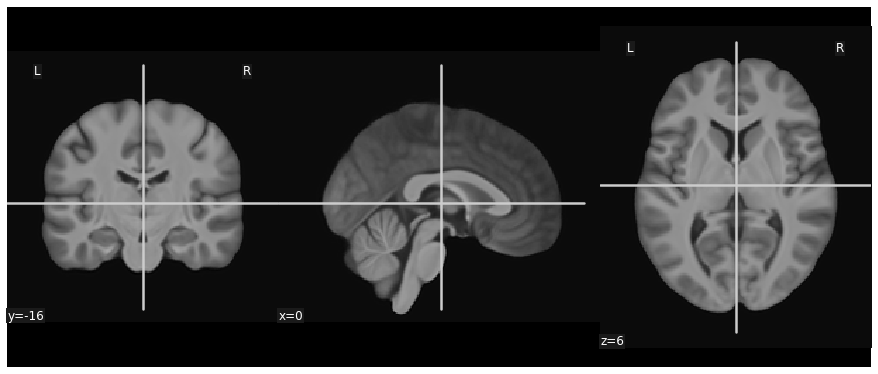

In [4]:
fig = plt.figure(figsize = (12,5))
plotting.plot_anat(anat_mean, black_bg = True, figure = fig)

In [17]:
maskfile_vmpfc = os.path.join(out_root, 'imaging', 'binConjunc_PvNxDECxRECxMONxPRI_vmpfc.nii.gz')
mask_vmpfc = nib.load(maskfile_vmpfc)
maskfile_striatum = os.path.join(out_root, 'imaging', 'binConjunc_PvNxDECxRECxMONxPRI_striatum.nii.gz')
mask_striatum = nib.load(maskfile_striatum)

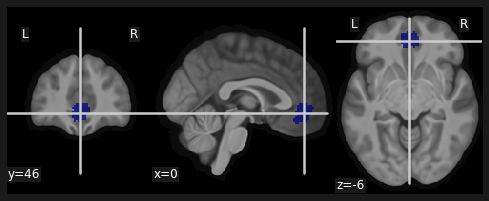

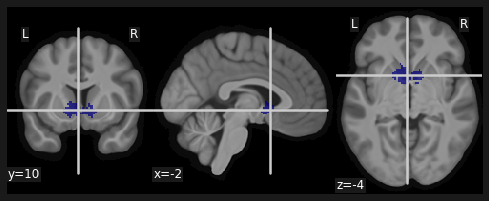

In [18]:
plotting.plot_roi(mask_vmpfc, bg_img = anat_mean)
plotting.plot_roi(mask_striatum, bg_img = anat_mean)

## Visualize individual GLM output

In [4]:
sub = 2073
cont1 = nib.load(os.path.join(data_root, '_subject_id_%s' %sub, 'con_0001.nii'))
spmt1 = nib.load(os.path.join(data_root, '_subject_id_%s' %sub, 'spmT_0001.nii'))

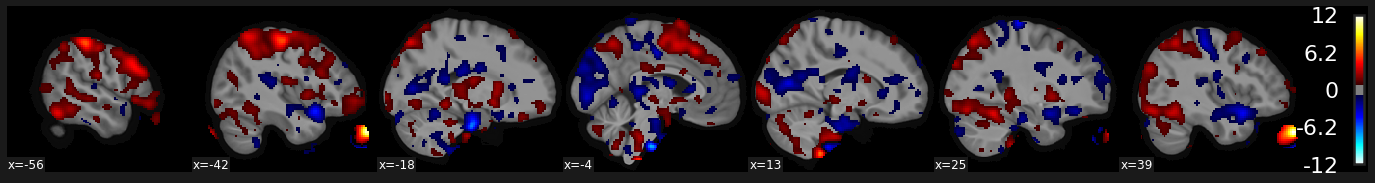

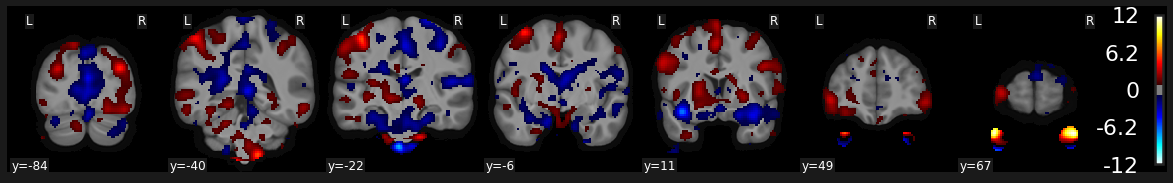

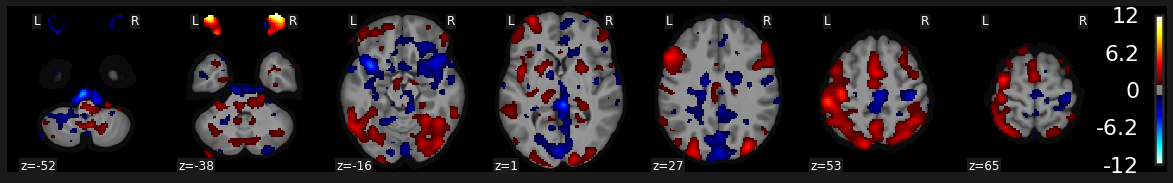

In [5]:
thr = 1
plotting.plot_stat_map(cont1, threshold = thr, bg_img = anat_mean, display_mode = 'x')
plotting.plot_stat_map(cont1, threshold = thr, bg_img = anat_mean, display_mode = 'y')
plotting.plot_stat_map(cont1, threshold = thr, bg_img = anat_mean, display_mode = 'z')

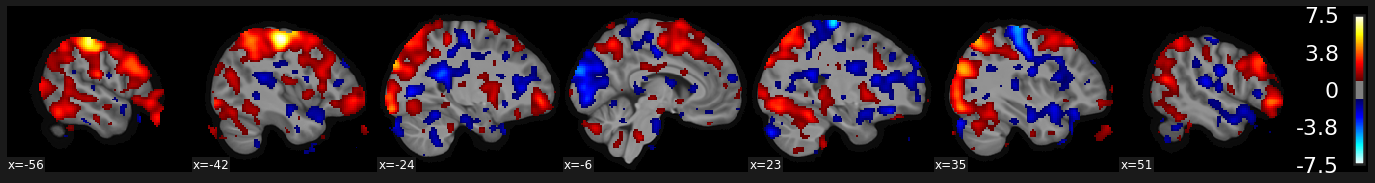

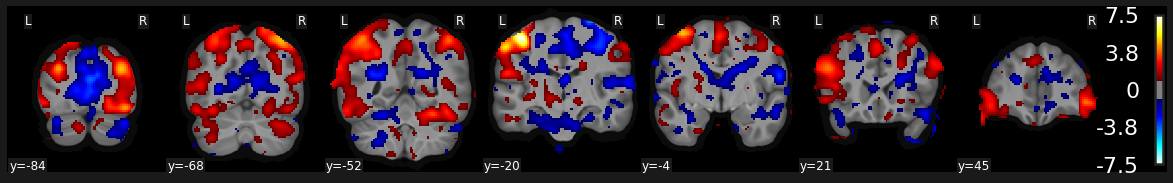

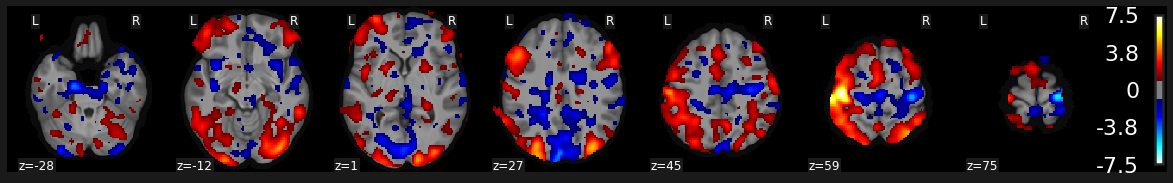

In [6]:
thr = 1
plotting.plot_stat_map(spmt1, threshold = thr, bg_img = anat_mean, display_mode = 'x')
plotting.plot_stat_map(spmt1, threshold = thr, bg_img = anat_mean, display_mode = 'y')
plotting.plot_stat_map(spmt1, threshold = thr, bg_img = anat_mean, display_mode = 'z')

## Visualize individual RDM

In [4]:
# load ROI masker
maskfile_vmpfc = os.path.join(out_root, 'imaging', 'binConjunc_PvNxDECxRECxMONxPRI_vmpfc.nii.gz')
maskfile_striatum = os.path.join(out_root, 'imaging', 'binConjunc_PvNxDECxRECxMONxPRI_striatum.nii.gz')

mask_striatum = nib.load(maskfile_striatum)
mask_vmpfc = nib.load(maskfile_vmpfc)

masker_striatum = NiftiMasker(mask_img=mask_striatum)
masker_vmpfc = NiftiMasker(mask_img=mask_vmpfc)


In [10]:
stims = {'01': 'Med_amb_0', '02': 'Med_amb_1', '03': 'Med_amb_2', '04': 'Med_amb_3',
         '05': 'Med_risk_0', '06': 'Med_risk_1', '07': 'Med_risk_2', '08': 'Med_risk_3', 
         '09': 'Mon_amb_0', '10': 'Mon_amb_1', '11': 'Mon_amb_2', '12': 'Mon_amb_3',
         '13': 'Mon_risk_0', '14': 'Mon_risk_1', '15': 'Mon_risk_2', '16': 'Mon_risk_3'}

stim_num = len(stims)

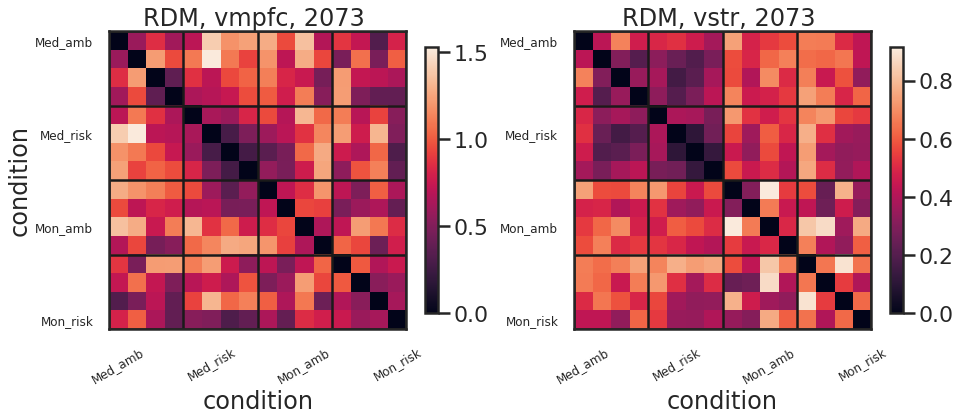

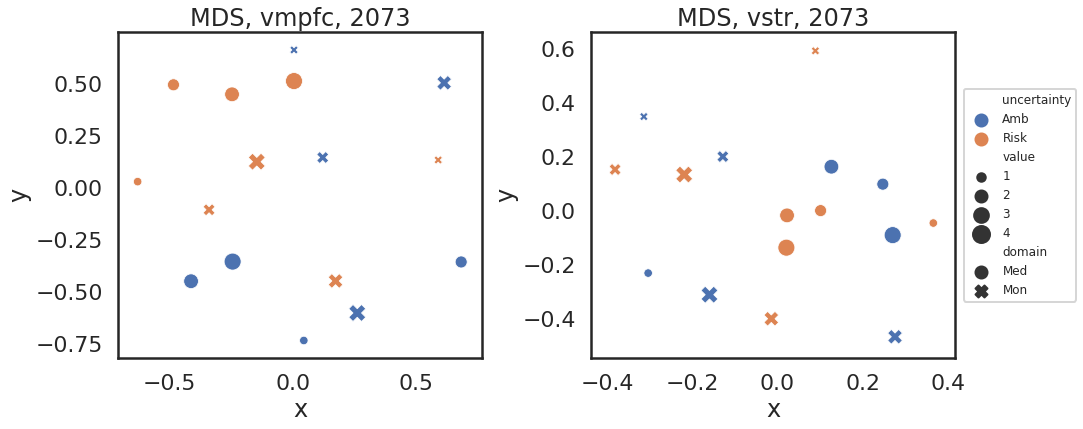

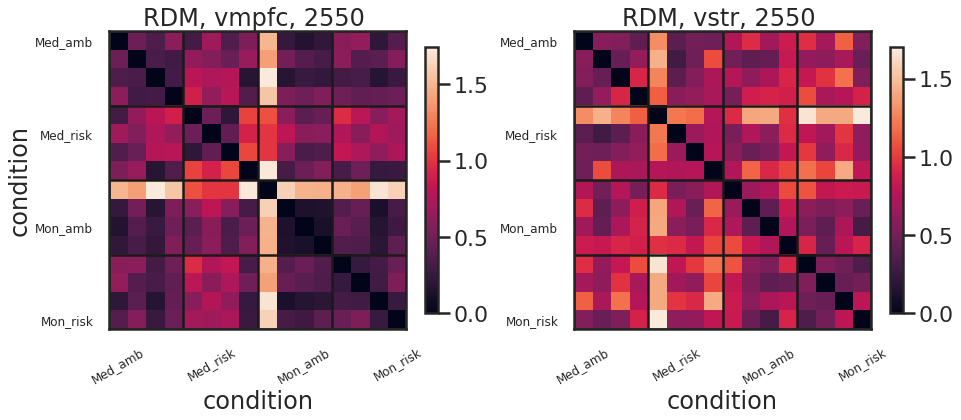

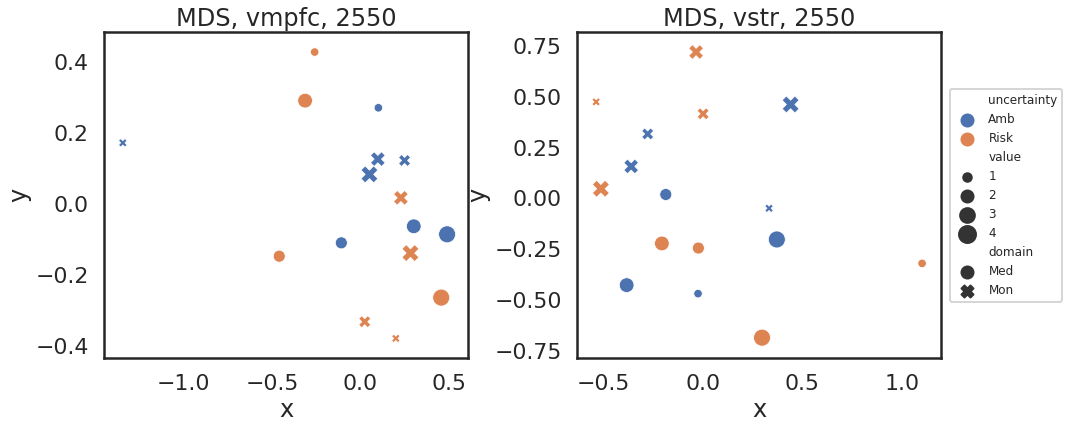

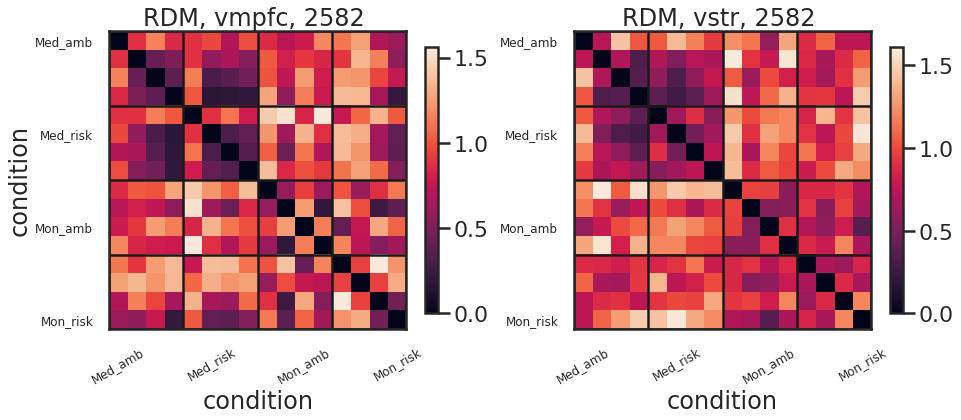

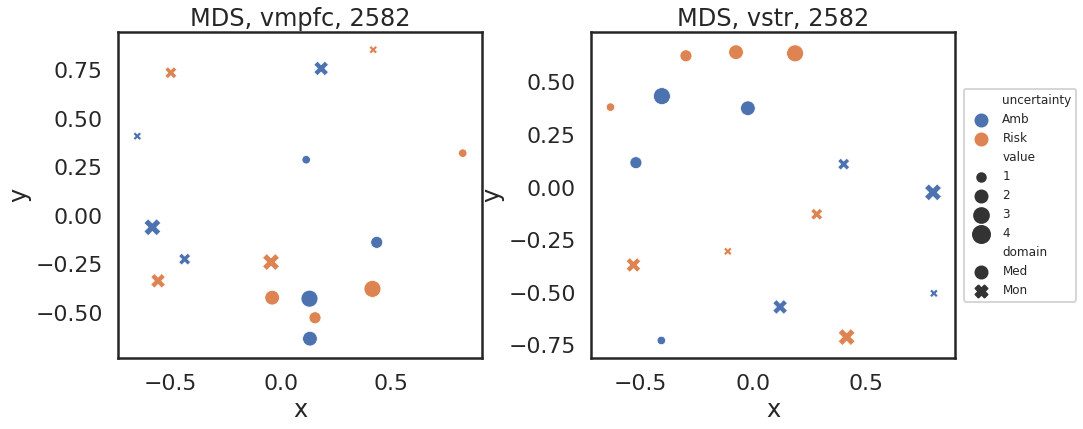

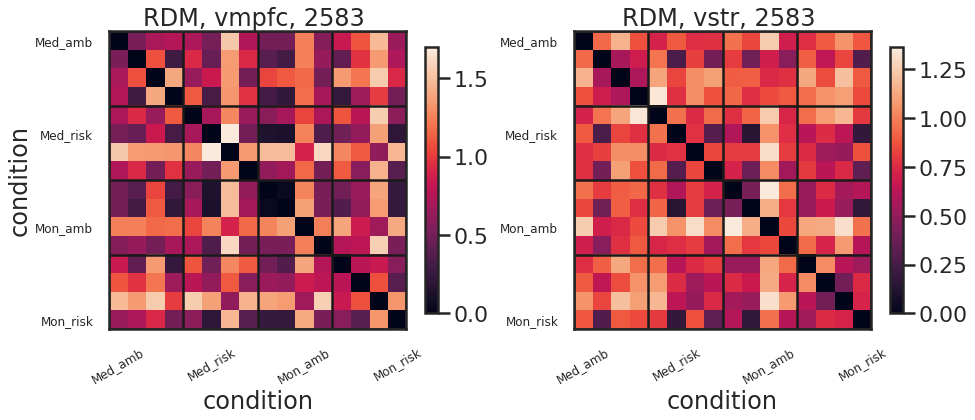

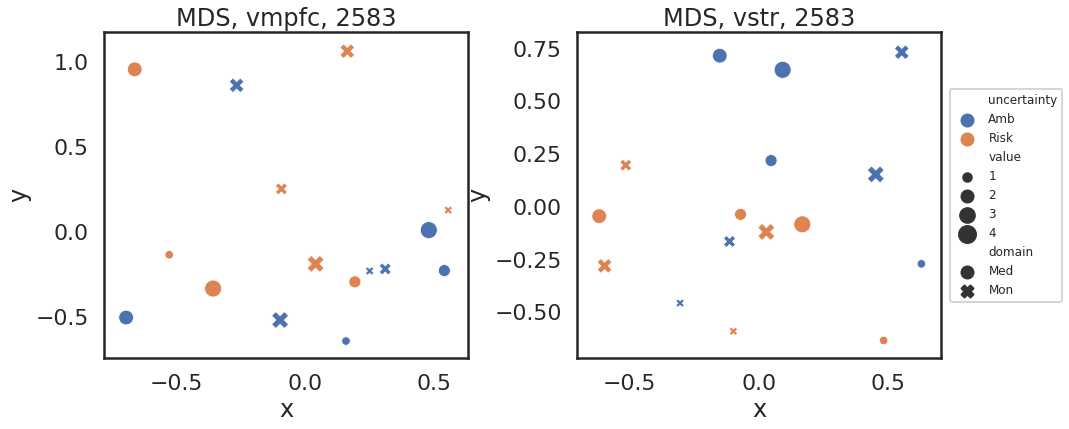

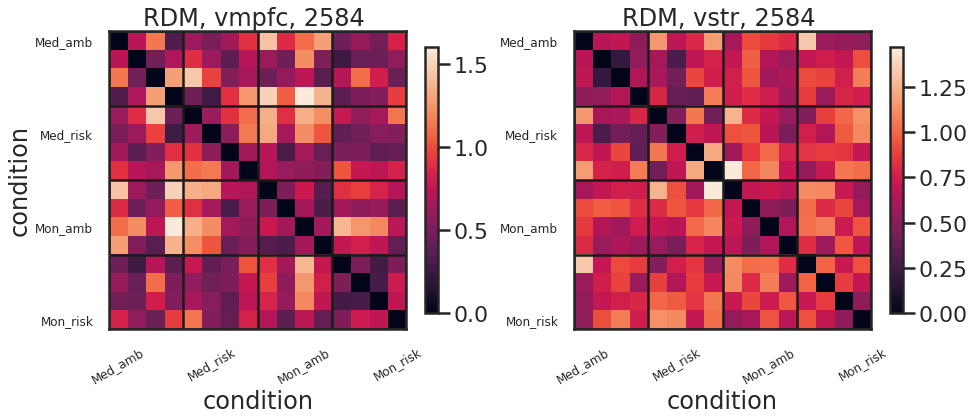

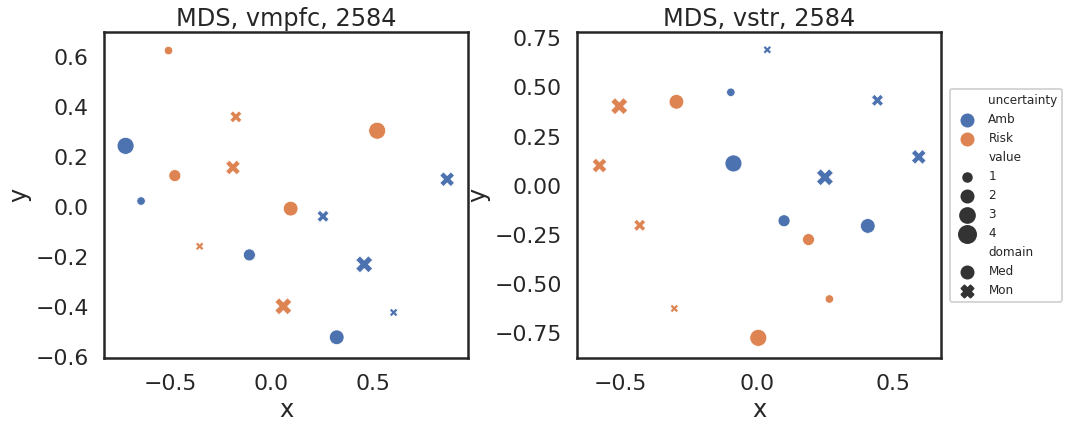

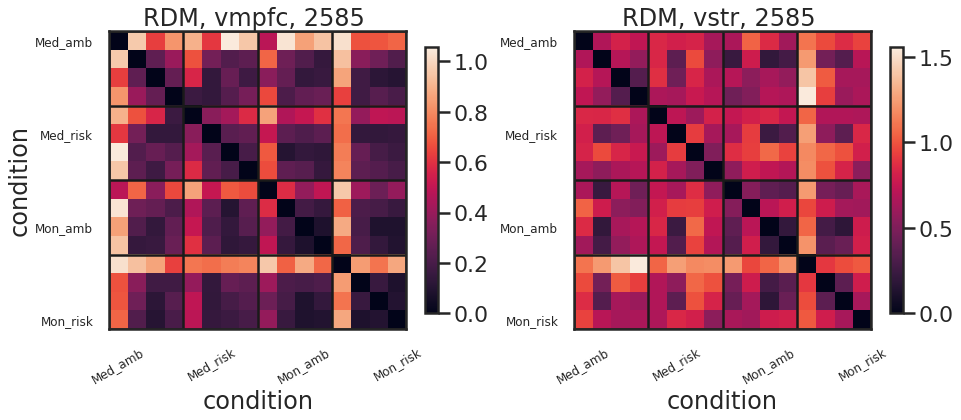

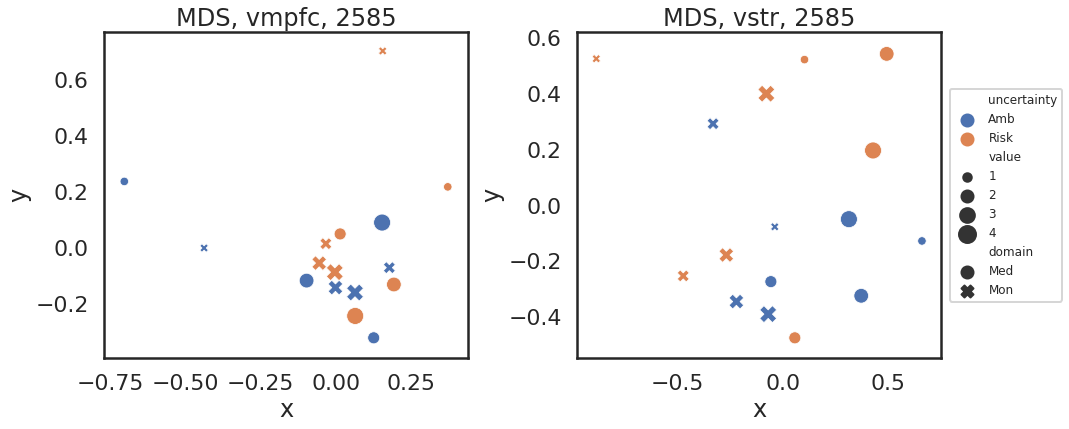

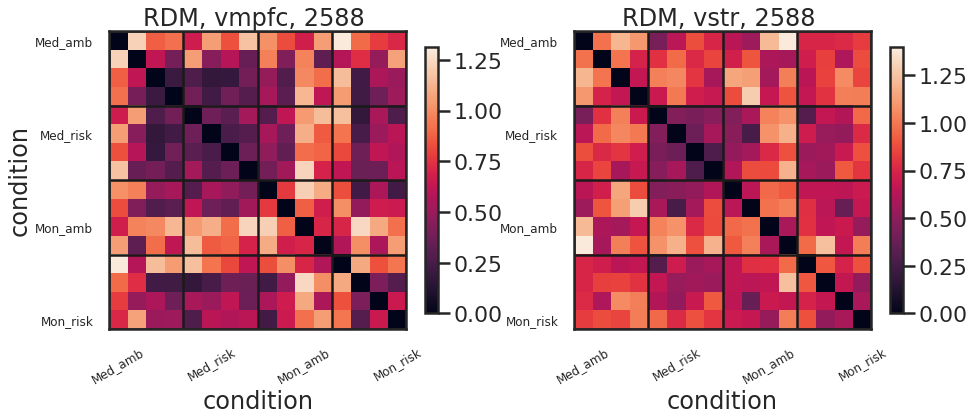

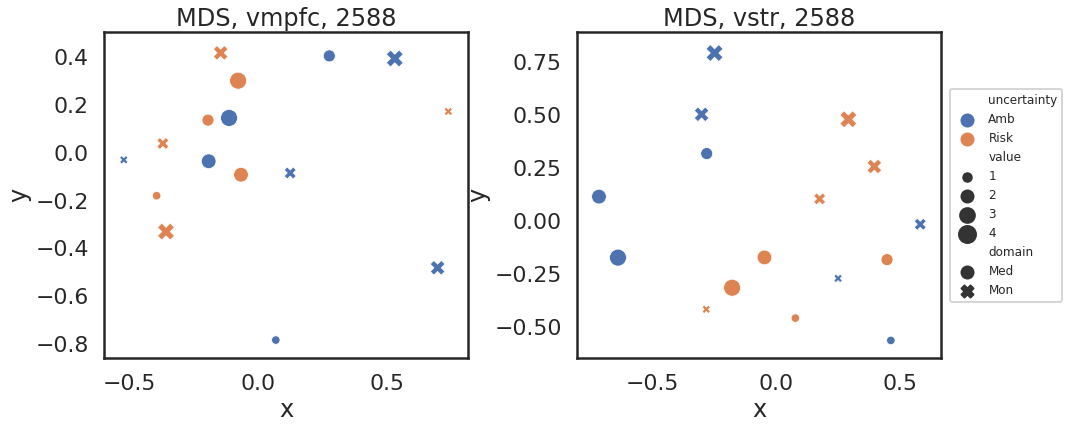

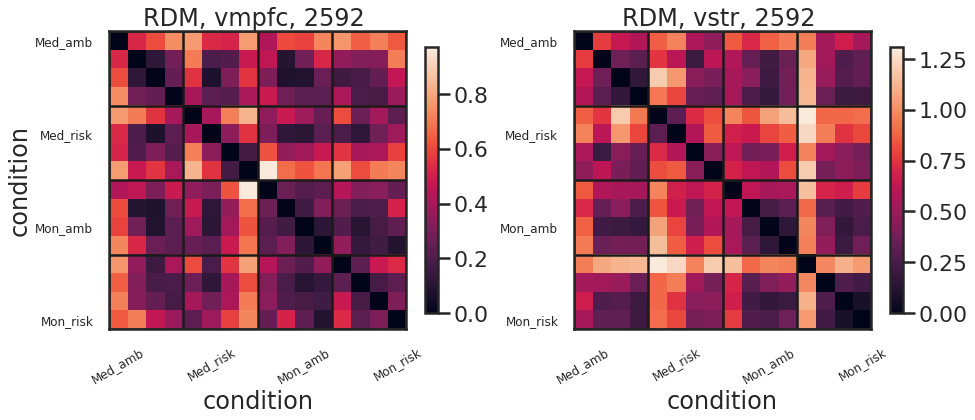

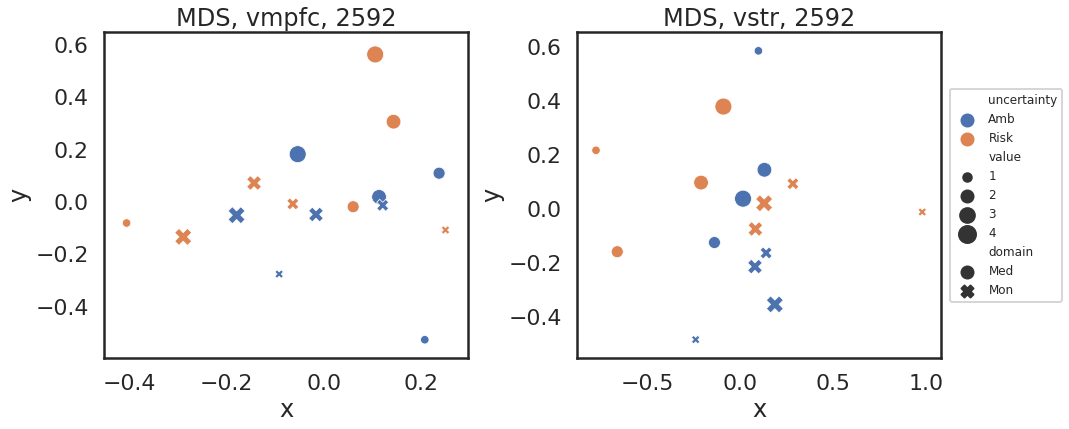

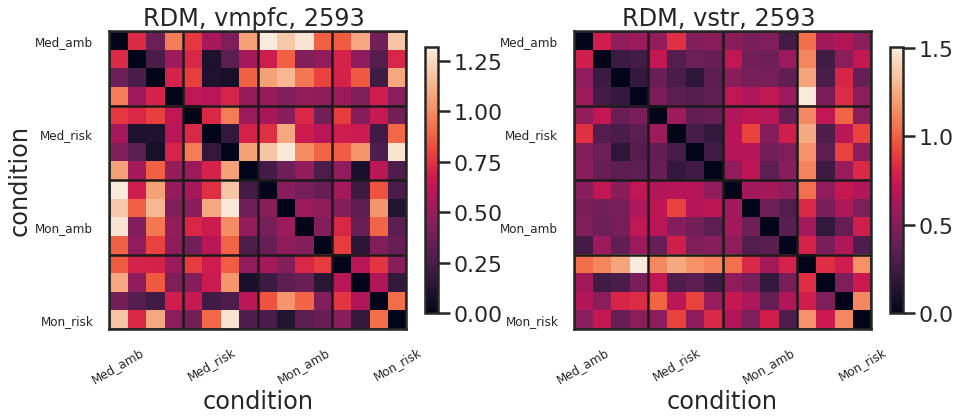

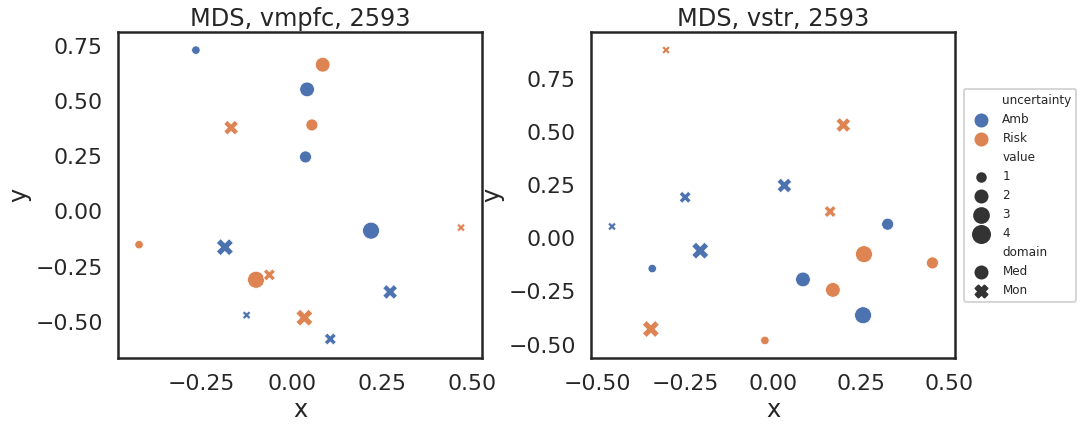

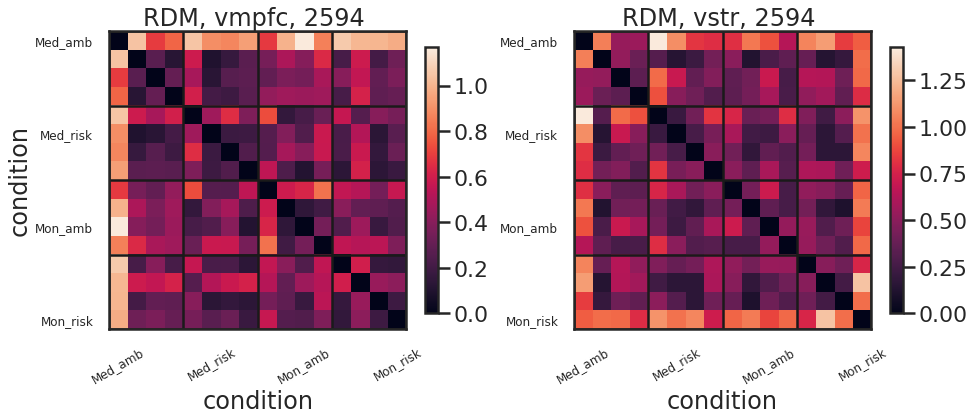

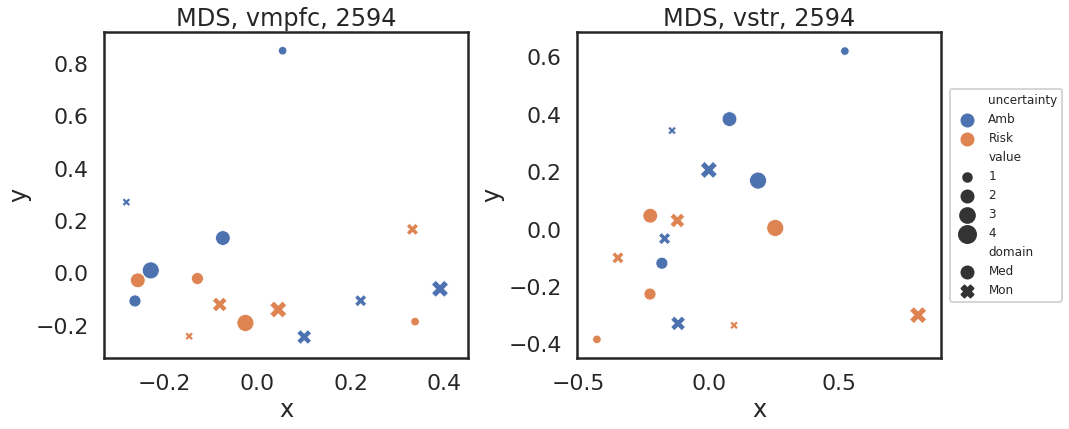

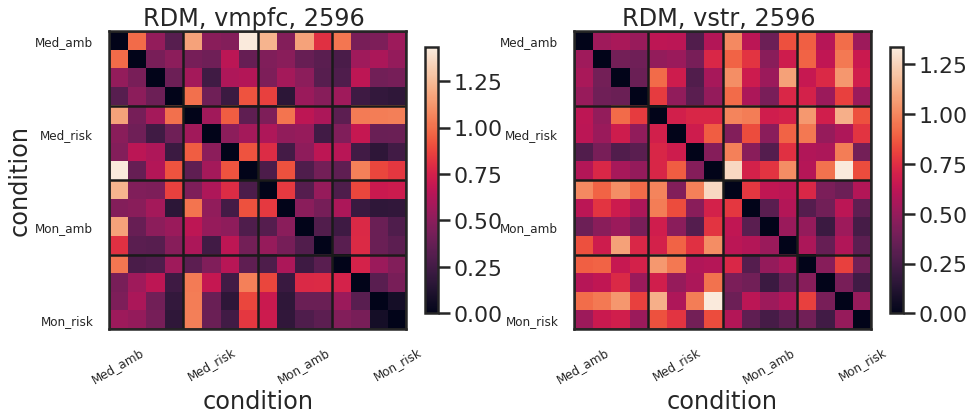

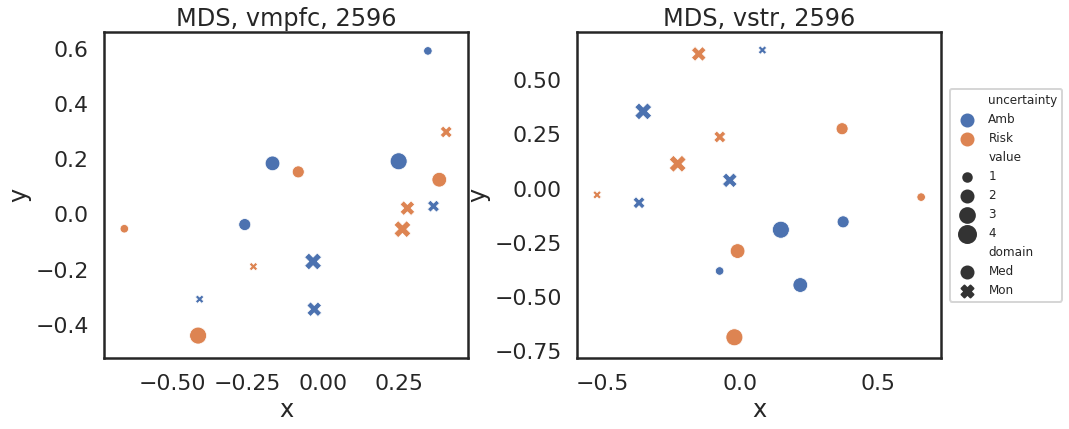

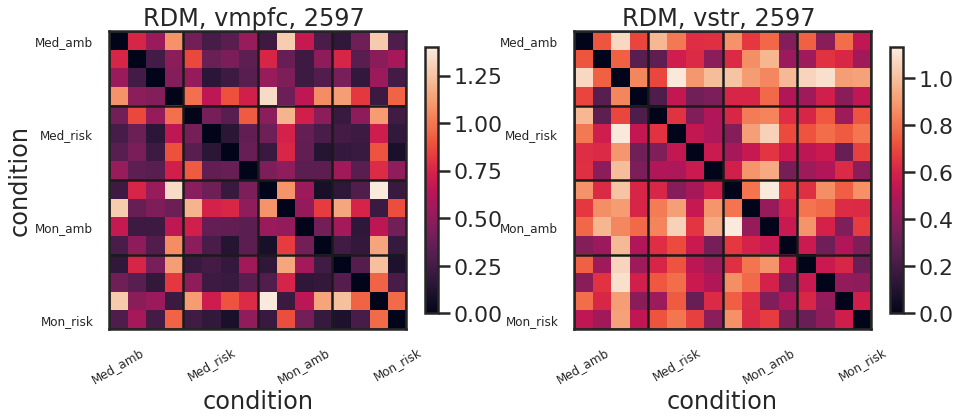

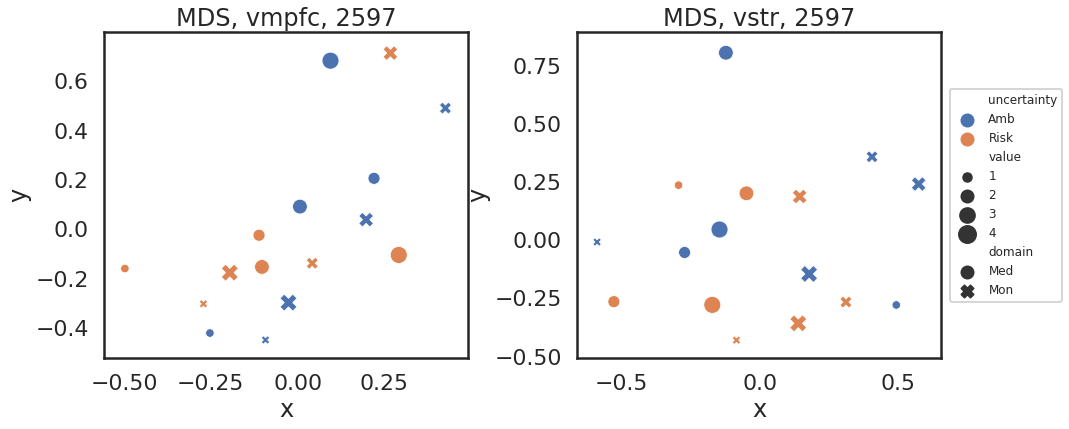

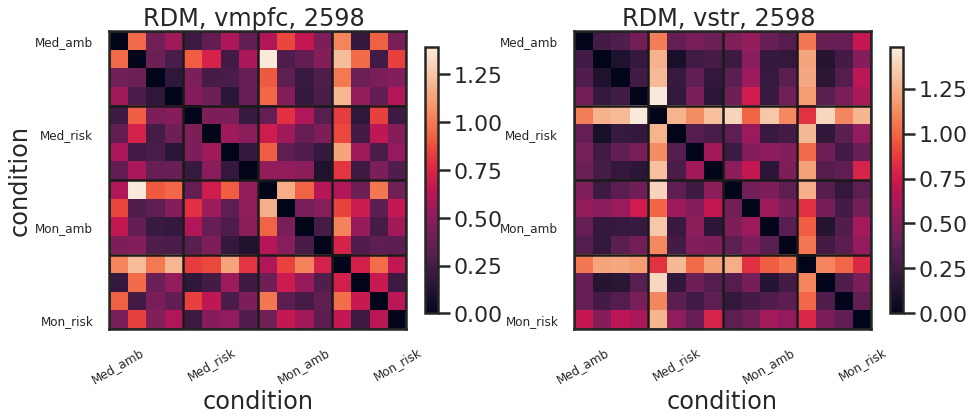

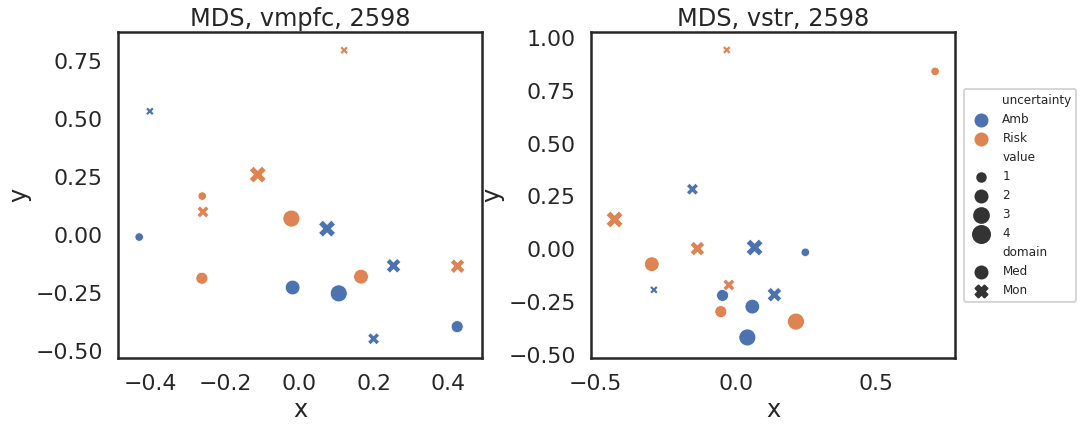

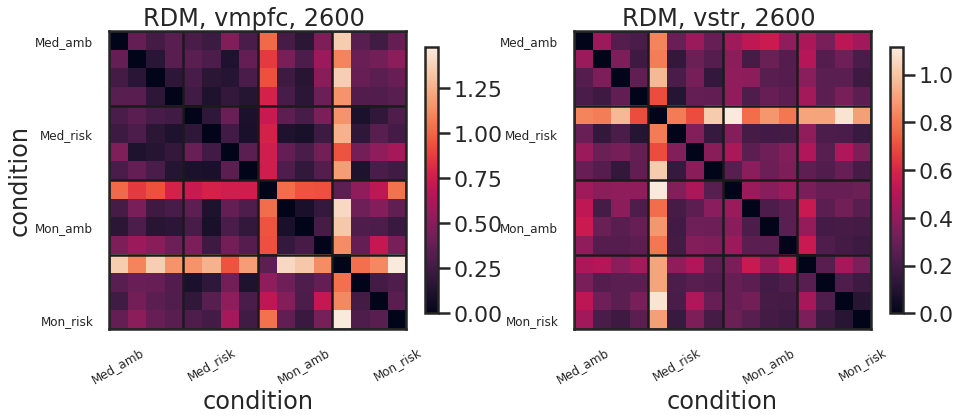

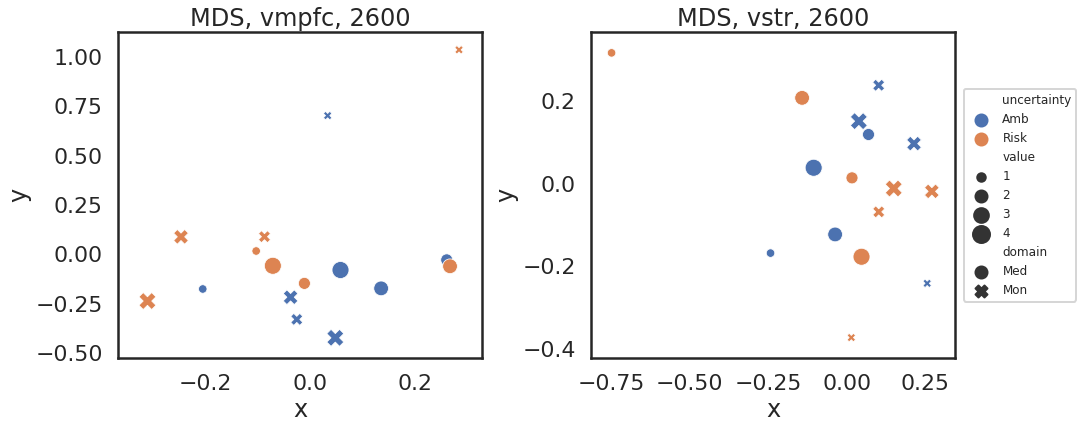

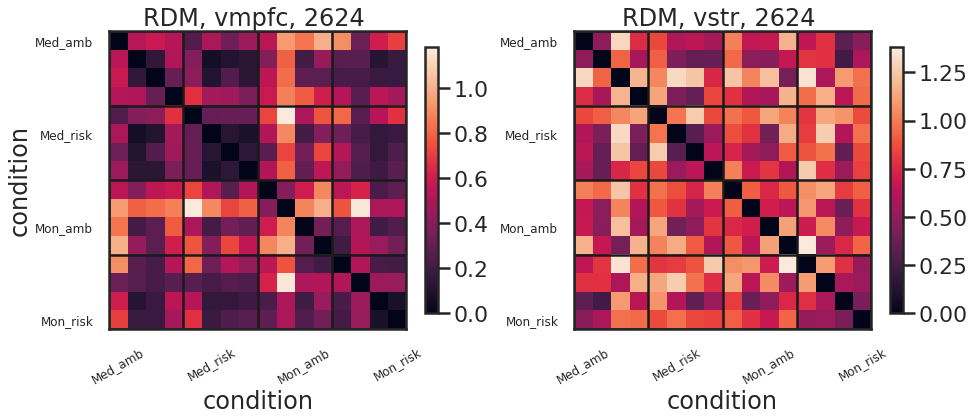

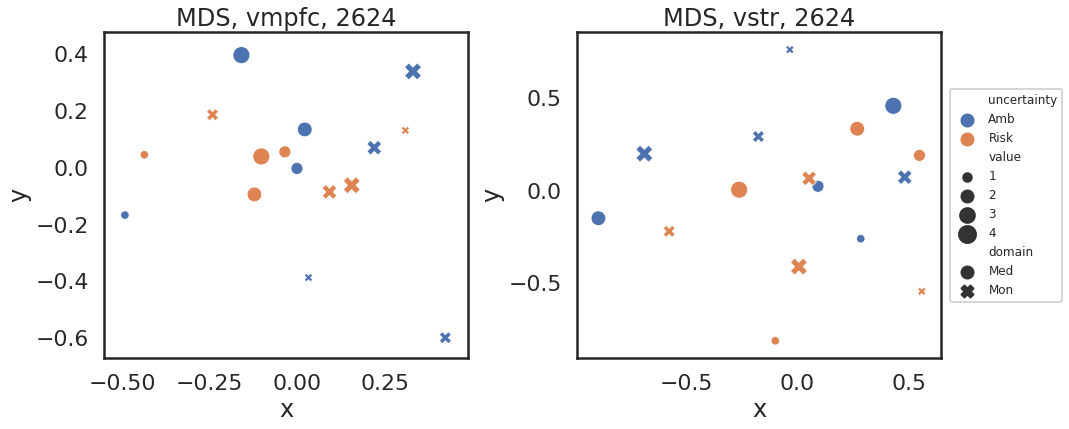

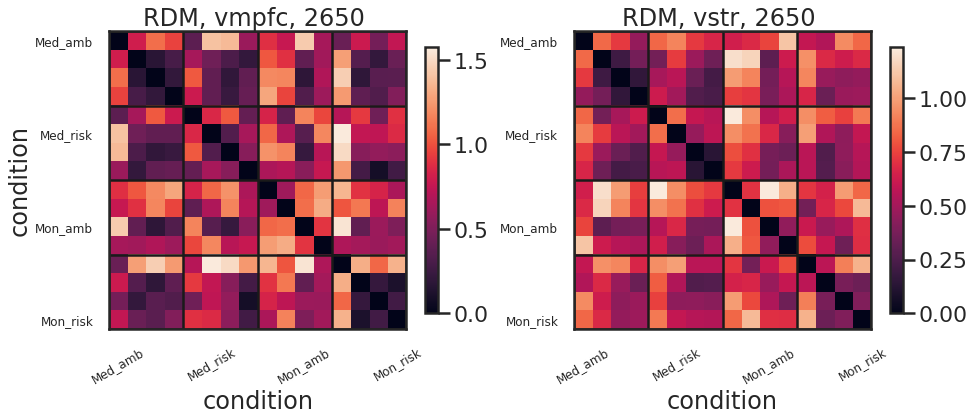

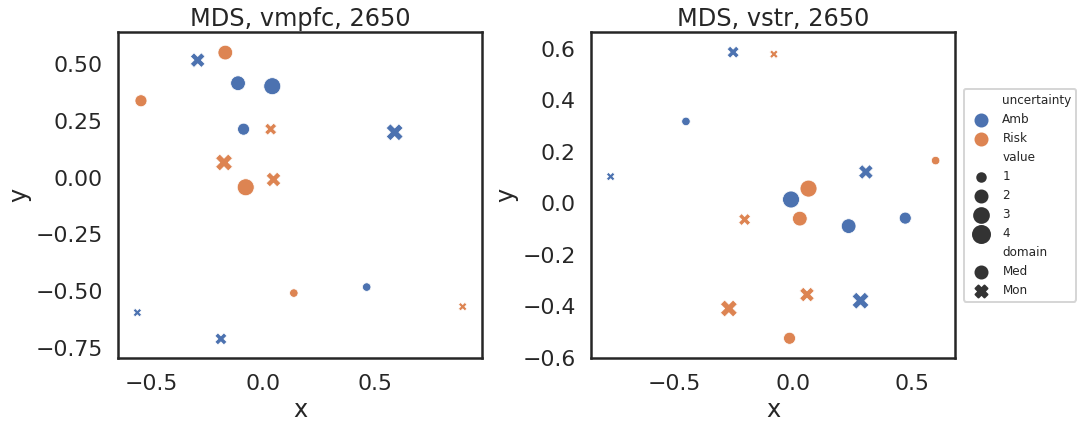

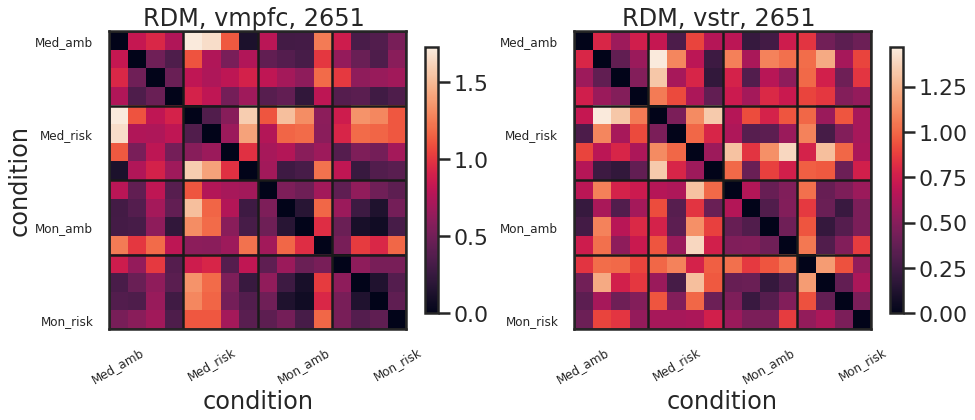

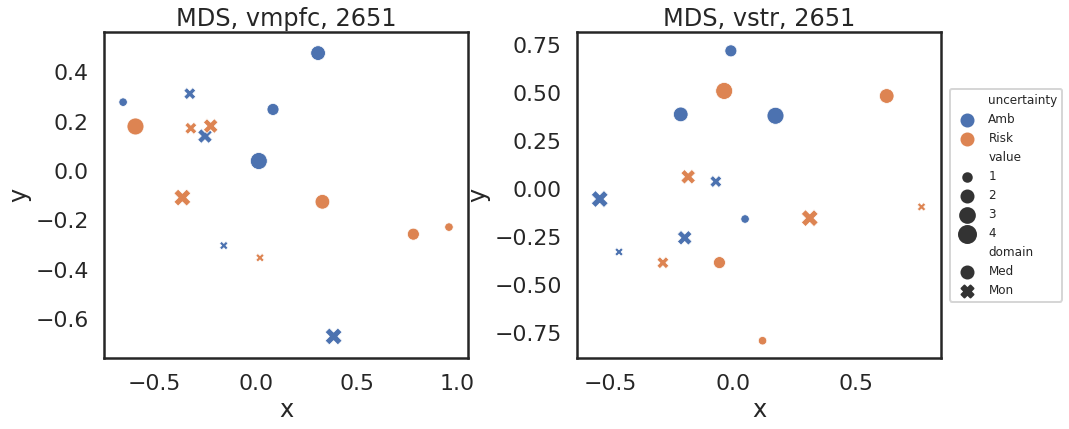

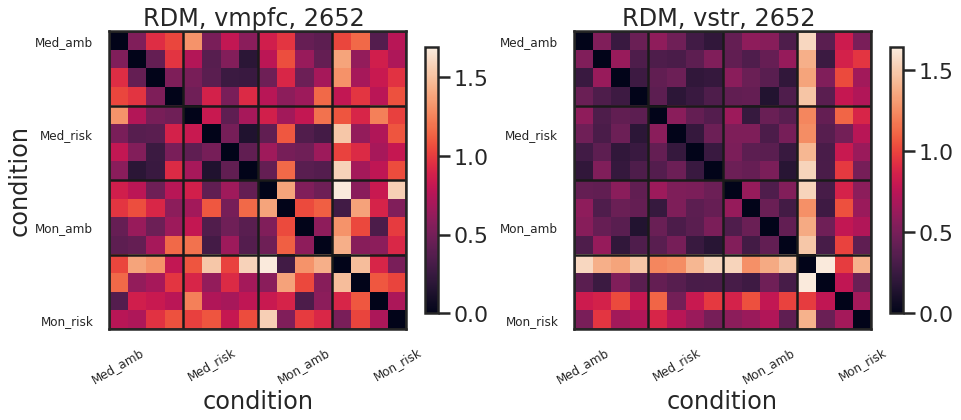

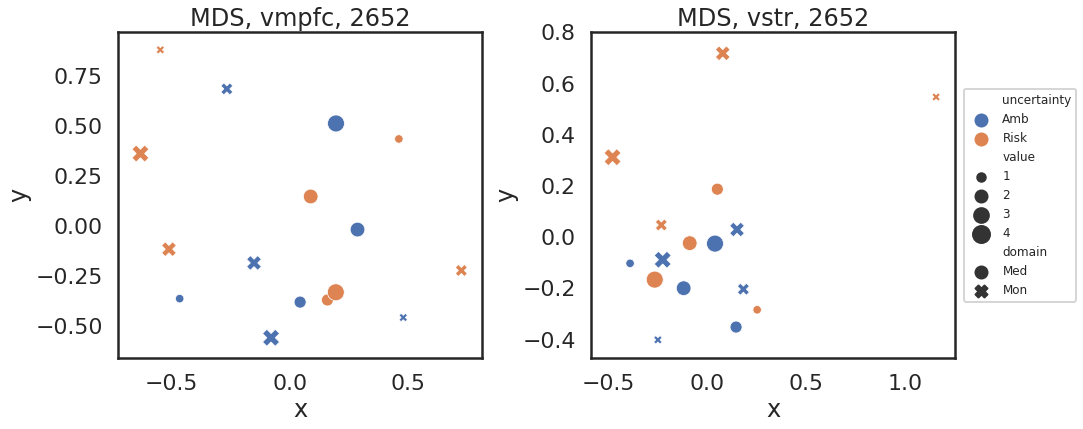

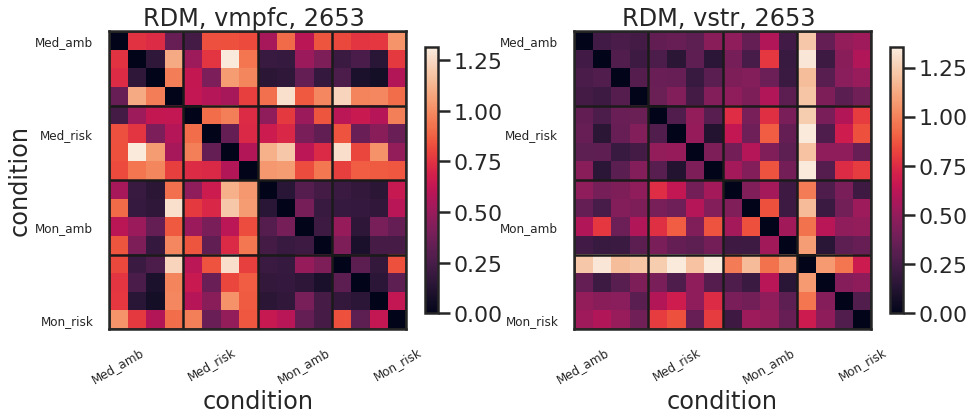

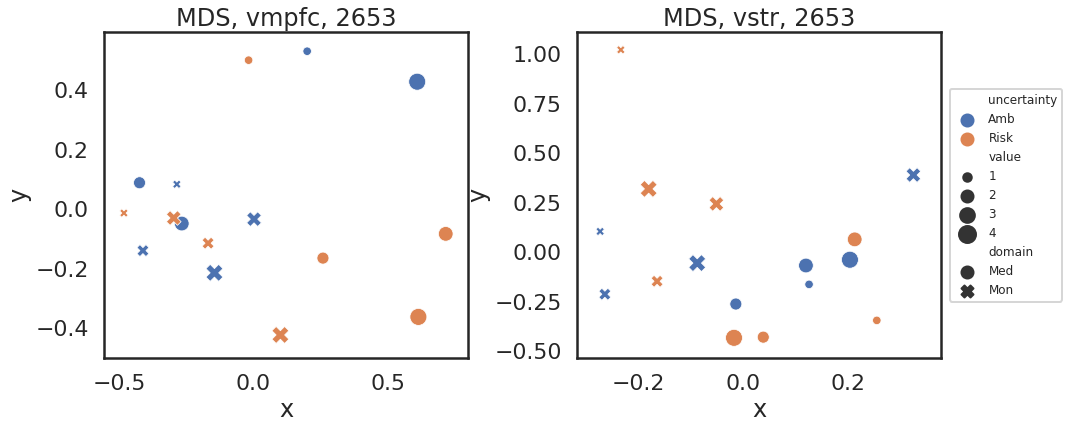

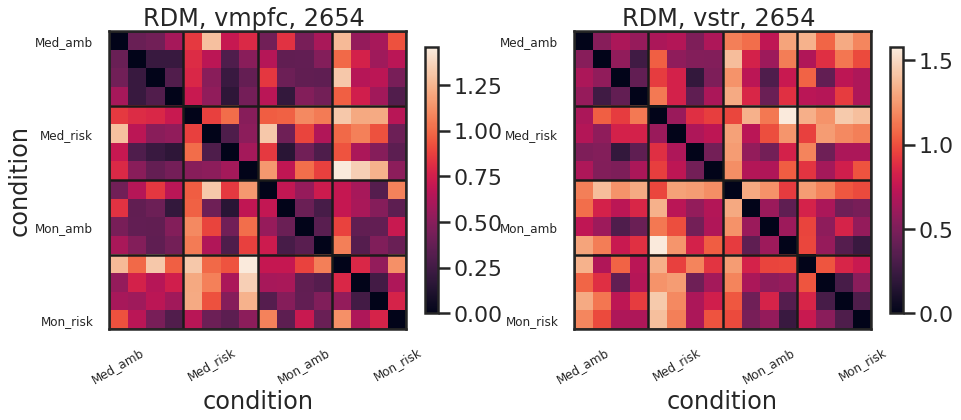

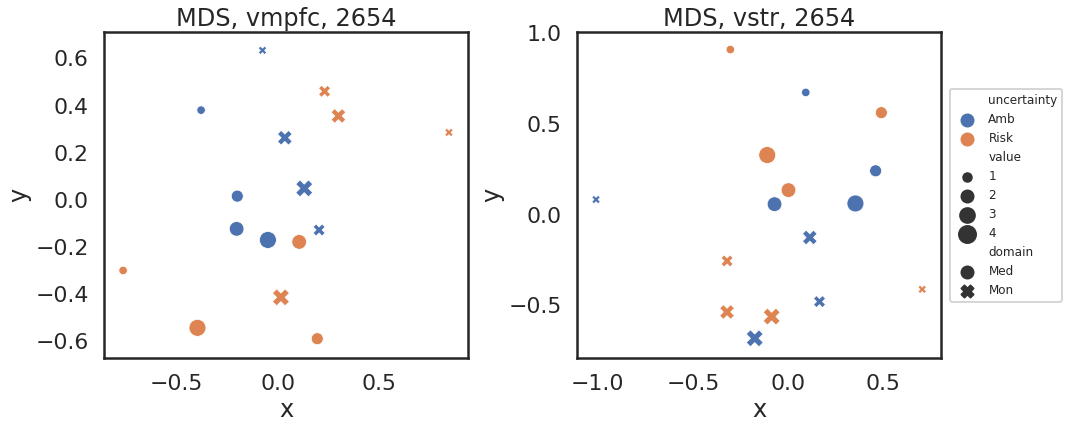

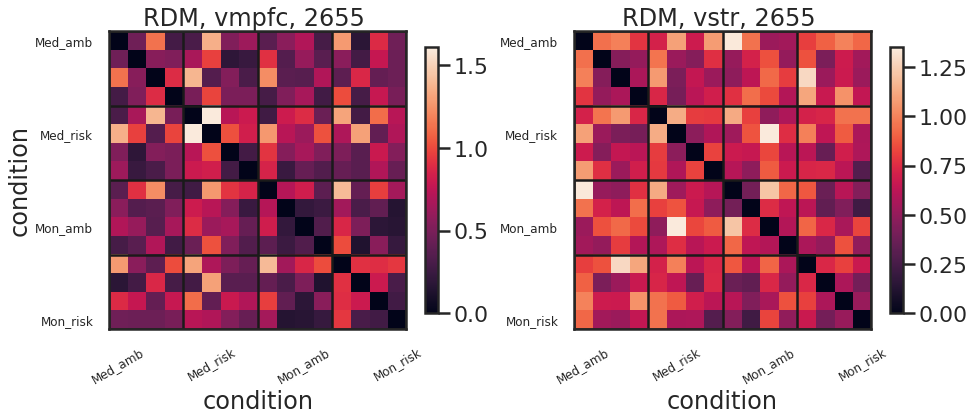

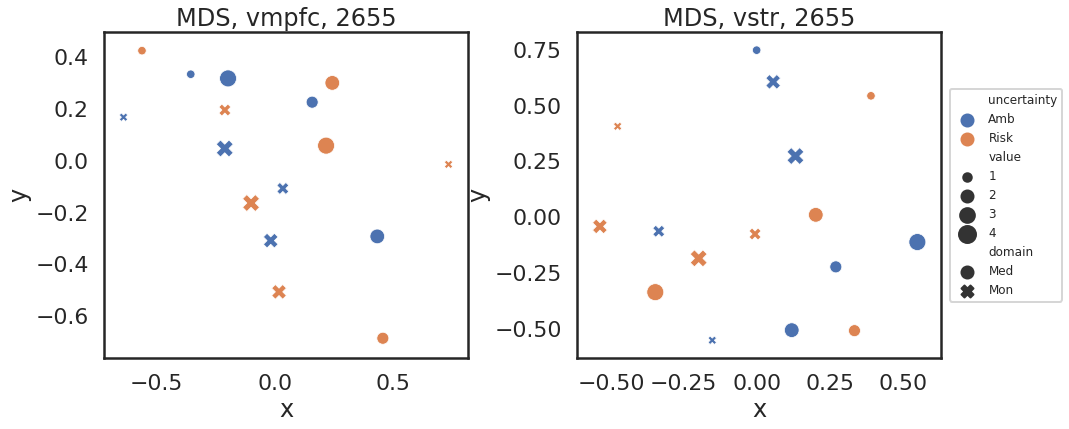

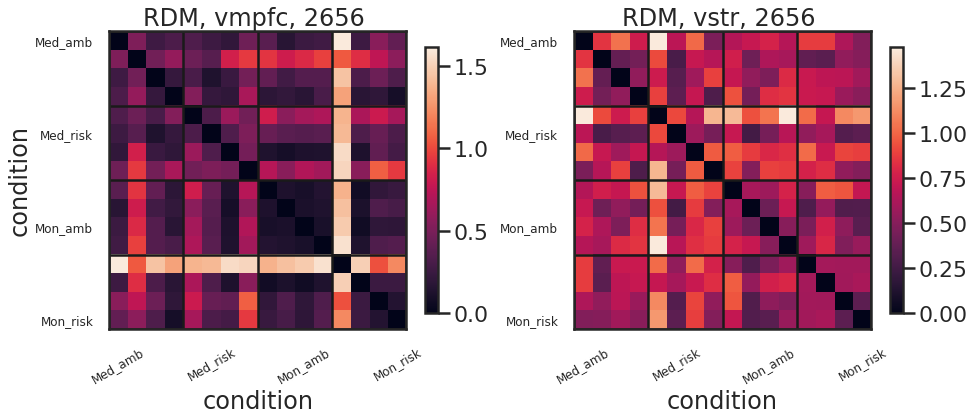

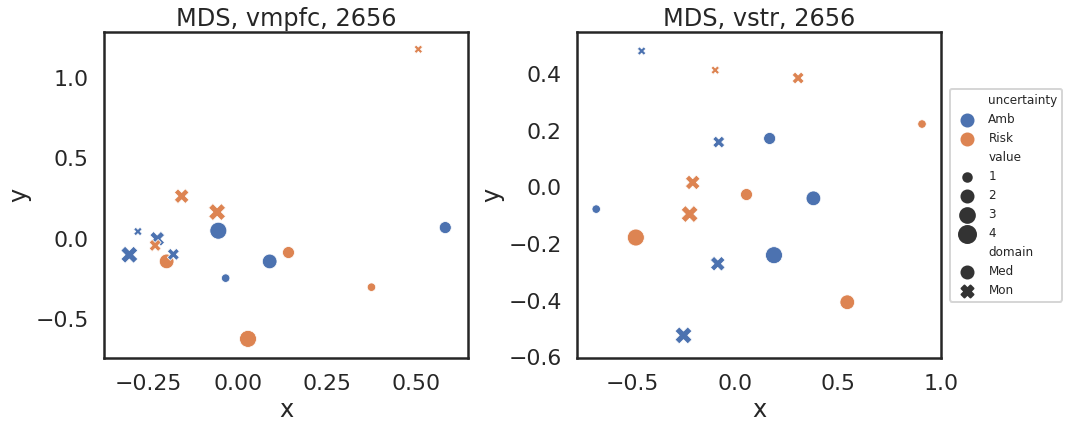

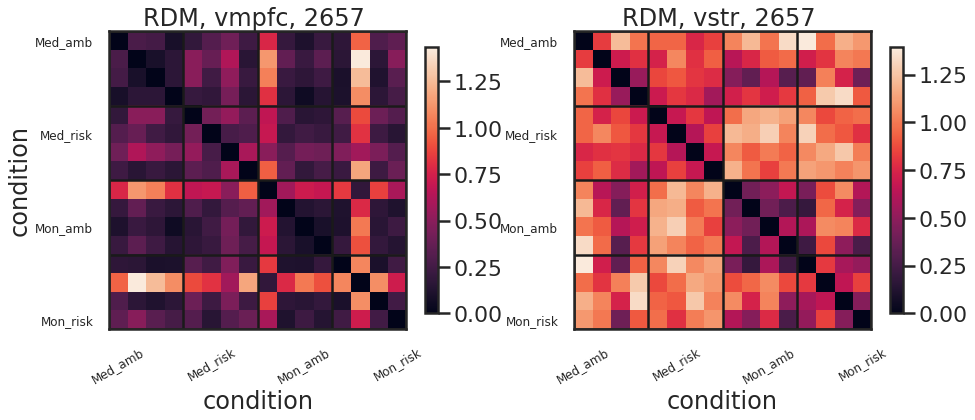

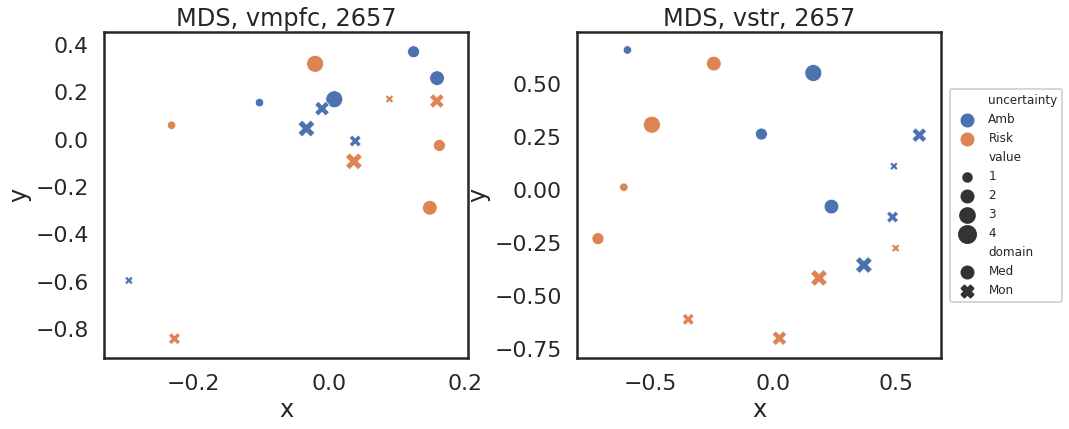

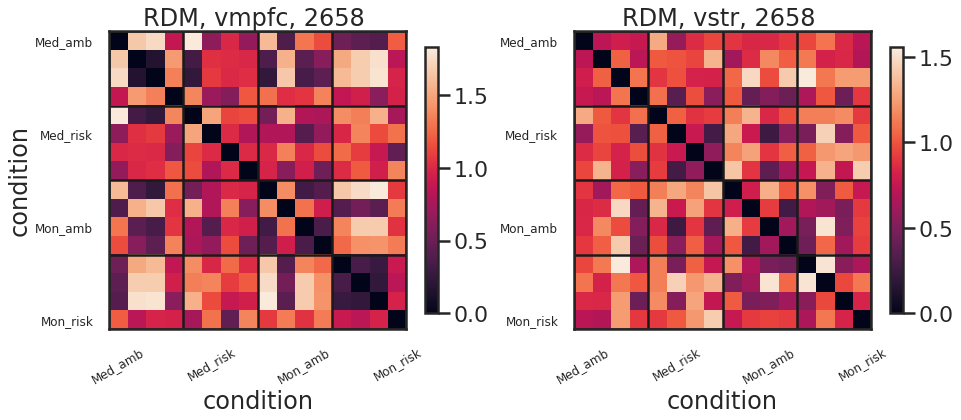

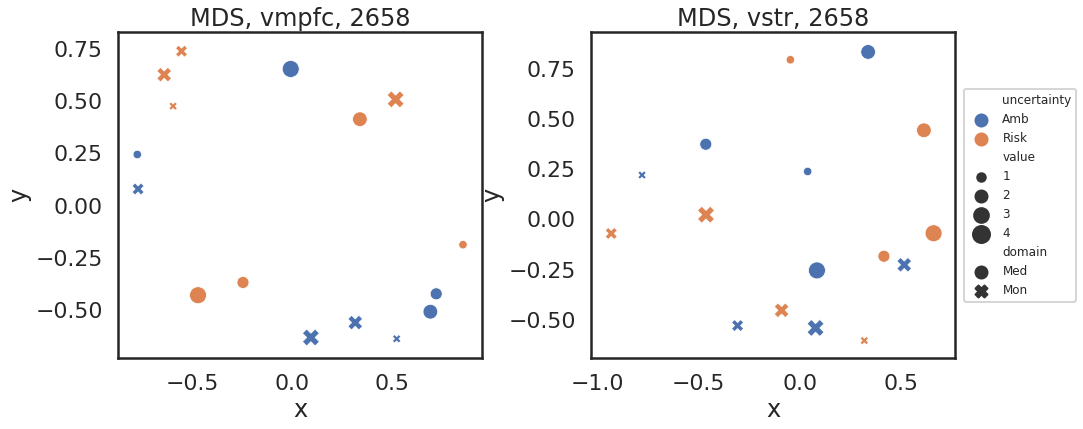

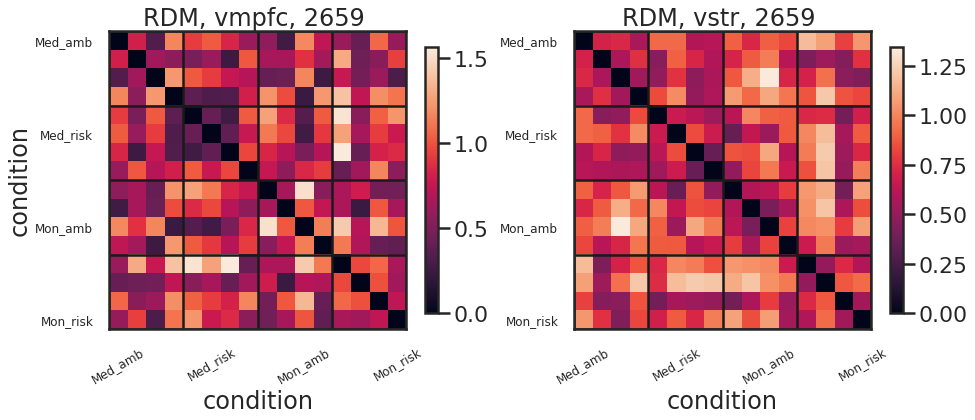

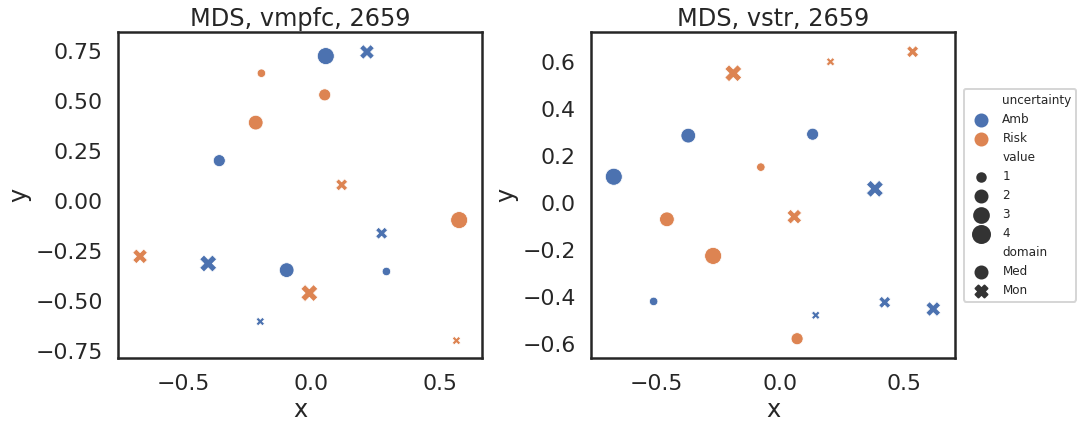

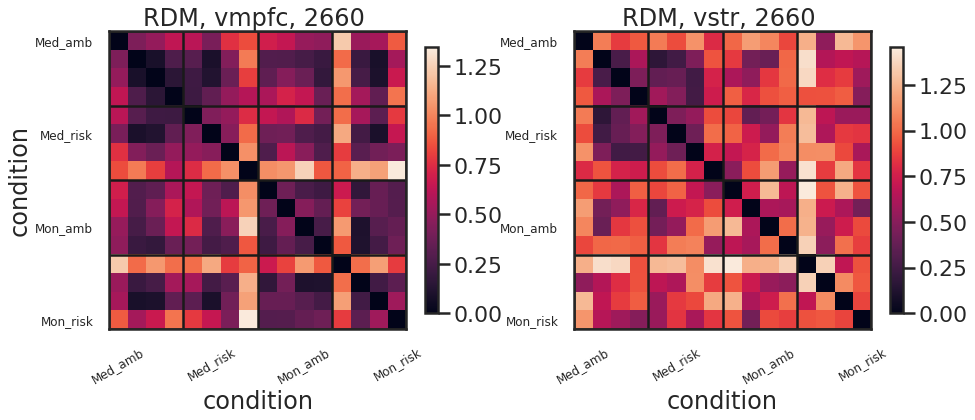

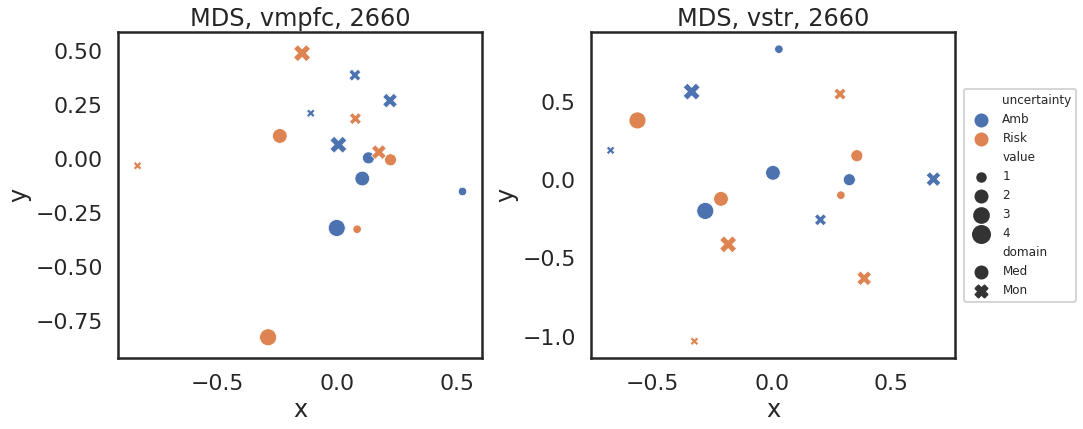

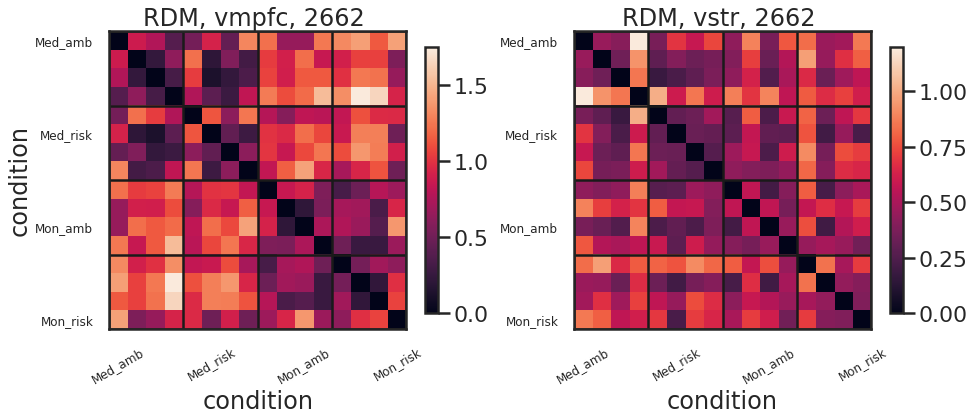

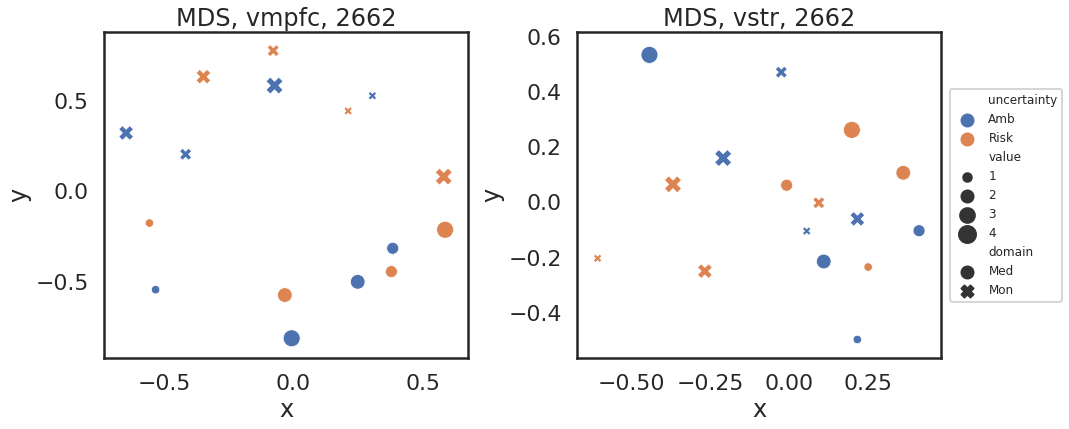

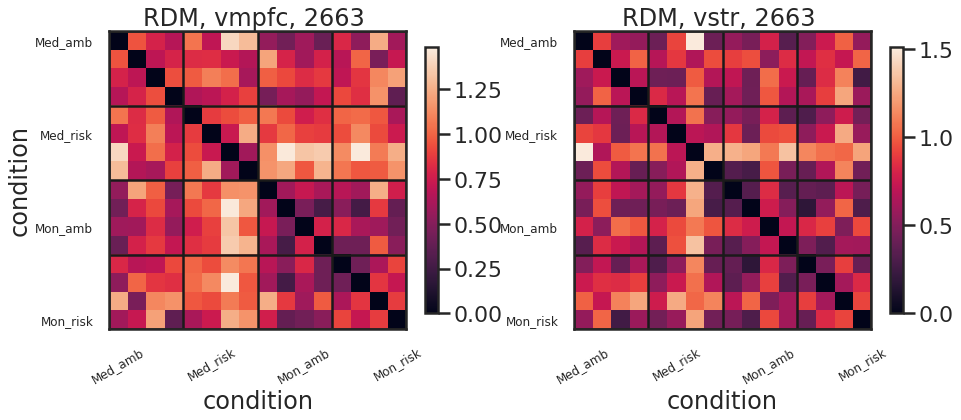

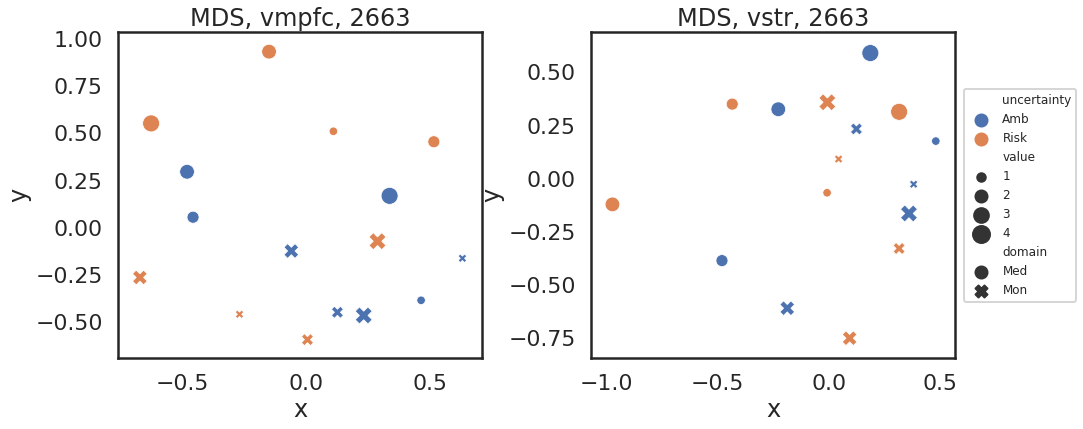

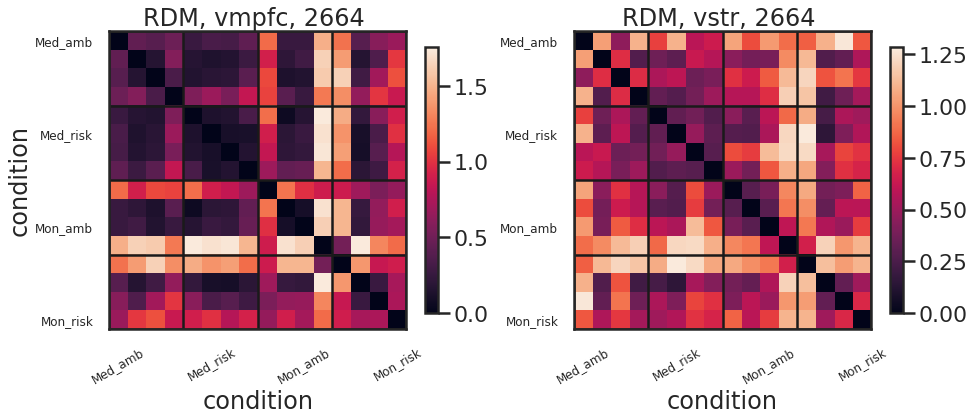

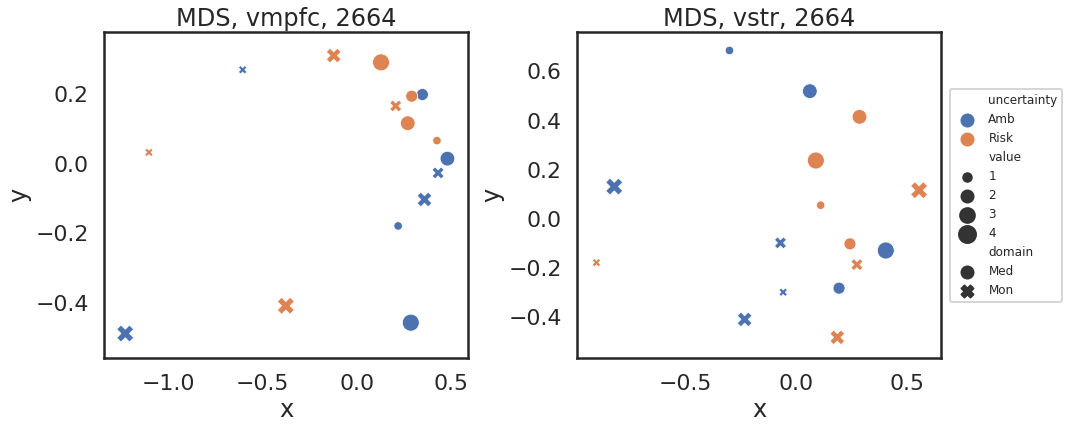

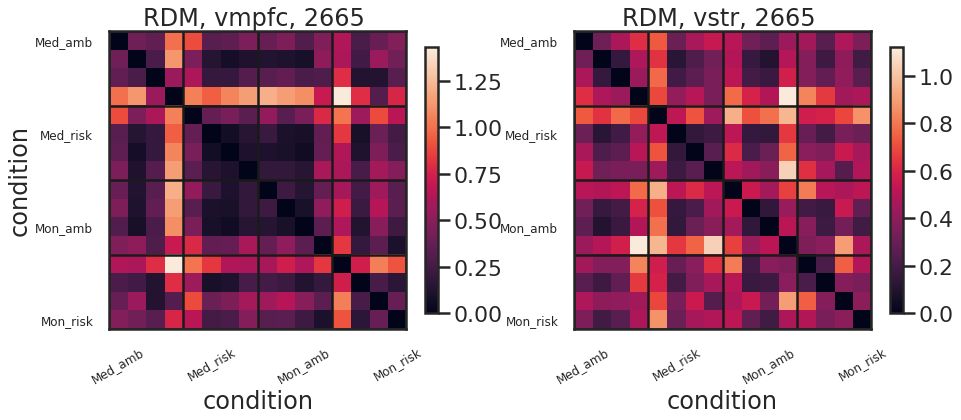

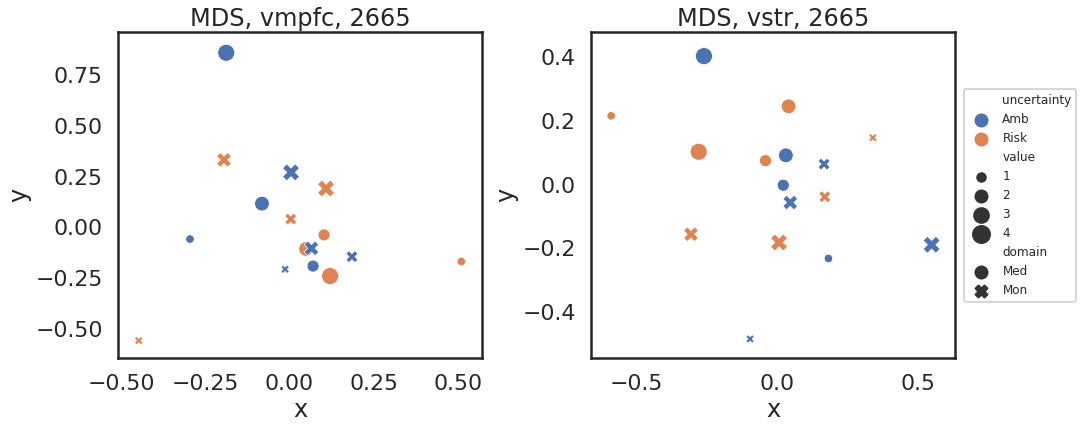

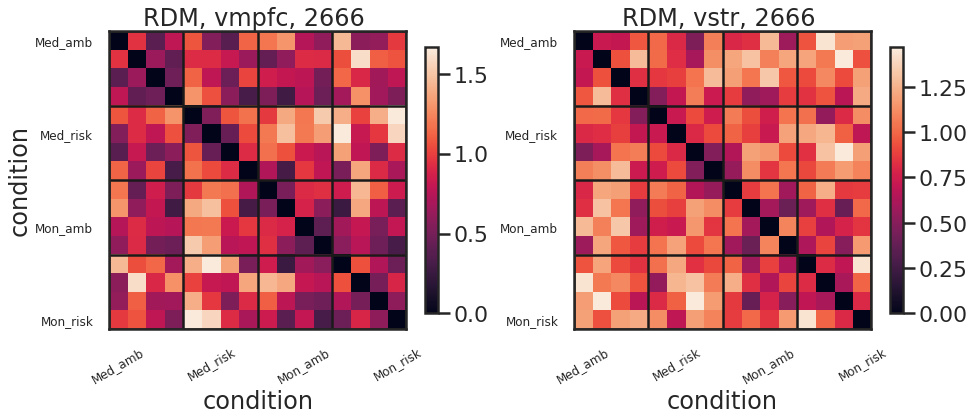

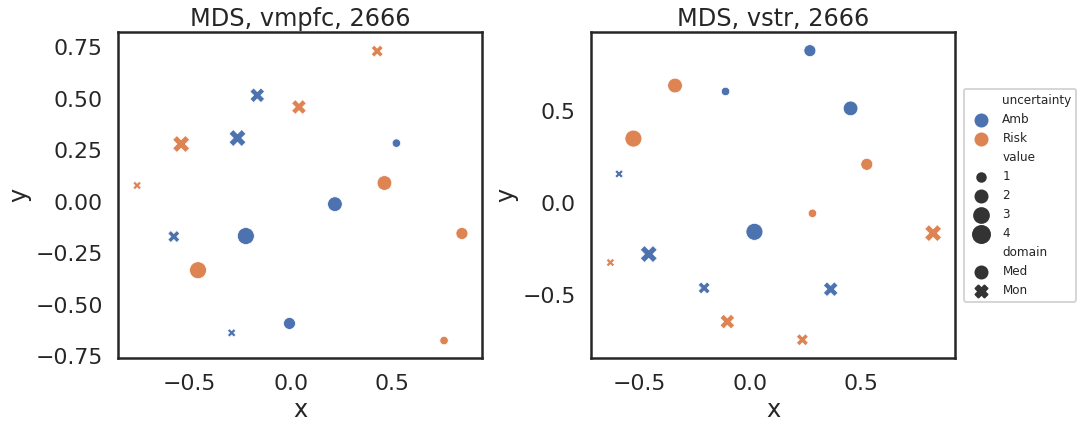

In [27]:
# single subject
subjects = [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 
            2593, 2594, 2596, 2597, 2598, 2600, 2624, 2650, 
            2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 
            2659, 2660, 2662, 2663, 2664, 2665, 2666]

# subjects = [2073]

for sub in subjects:
    roi_rdm_obj = np.load('/home/rj299/project/mdm_analysis/output/imaging/Sink_rsa/rdm/_subject_id_%s/roi_rdm.npy' %sub,
           allow_pickle = True)

    roi_rdm = roi_rdm_obj.item()

    stim_cat = ['', 'Med_amb', 'Med_risk', 'Mon_amb', 'Mon_risk']
    fontdict = {'fontsize': 12}
    edges = np.array([0,4,8,12,16])-0.5
    roi_names = list(roi_rdm.keys())

    f, ax = plt.subplots(1,len(roi_names), figsize=(15, 7))

    for roi_idx in range(len(roi_names)):
        im = ax[roi_idx].imshow(roi_rdm[roi_names[roi_idx]])
        ax[roi_idx].set_xticklabels(stim_cat, rotation = 30, fontdict = fontdict)
        ax[roi_idx].set_yticklabels(stim_cat, fontdict = fontdict)
        ax[roi_idx].set_title('RDM, '+roi_names[roi_idx] + ', %s ' %sub) 
        ax[roi_idx].set_xlabel('condition')
        if roi_idx == 0:
            ax[roi_idx].set_ylabel('condition')
        else:
            ax[roi_idx].set_ylabel('')
        ax[roi_idx].vlines(edges,min(edges),max(edges))
        ax[roi_idx].hlines(edges,min(edges),max(edges))
        f.colorbar(im, ax=ax[roi_idx], shrink = 0.7)


    f.subplots_adjust(wspace = 0.25)
    
    f1, ax1 = plt.subplots(1,len(roi_names), figsize=(15, 6))
    
    for (roi_idx, roi_name) in enumerate(roi_names):
        # Create the MDS object
        mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
        results = mds.fit(roi_rdm[roi_name])

        coords = results.embedding_

        value = [1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4] 
        uncert = ['Amb','Amb','Amb','Amb','Risk','Risk','Risk','Risk',
                  'Amb','Amb','Amb','Amb','Risk','Risk','Risk','Risk']
        domain = ['Med','Med','Med','Med','Med','Med','Med','Med',
                  'Mon','Mon','Mon','Mon','Mon','Mon','Mon','Mon']

        mds_coord = pd.DataFrame({'x': coords[:,0], 'y': coords[:,1], 'value': value,
                    'uncertainty': uncert, 'domain': domain})    


        sns.scatterplot(x='x', y = 'y',
                        size = 'value', hue = 'uncertainty', style = 'domain',
                        data=mds_coord, legend = 'full',
                        ax = ax1[roi_idx])
        
        if roi_idx == len(roi_names)-1:
            ax1[roi_idx].legend(fontsize = 12, markerscale = 1, loc = 'right', bbox_to_anchor=(1.35, .5))
        else:
            ax1[roi_idx].legend().remove()
            
        ax1[roi_idx].set_title('MDS, ' + roi_name + ', %s' %sub);
        
    f1.subplots_adjust(wspace = 0.3)

## Visualize group average RDM

In [43]:
# get subject average rdm
subjects = [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 
            2593, 2594, 2596, 2597, 2598, 2600, 2624, 2650, 
            2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 
            2659, 2660, 2662, 2663, 2664, 2665, 2666]
roi_rdm_0 = []
roi_rdm_1 = []

for sub in subjects:
    roi_rdm_sub_obj = np.load('/home/rj299/project/mdm_analysis/output/imaging/Sink_rsa/rdm/_subject_id_%s/roi_rdm.npy' %sub,
       allow_pickle = True)
    
    roi_rdm_sub = roi_rdm_sub_obj.item()
    roi_names = list(roi_rdm_sub.keys())
    
    roi_rdm_0.append(roi_rdm_sub[roi_names[0]])
    roi_rdm_1.append(roi_rdm_sub[roi_names[1]])
    
roi_rdm = {roi_names[0]: roi_rdm_0, roi_names[1]: roi_rdm_1}    

In [44]:
print('Number of subjects: %s' %len(roi_rdm['vmpfc']))
print('Size of RDM:', np.mean(roi_rdm['vmpfc'], axis = 0).shape)

Number of subjects: 31
Size of RDM: (16, 16)


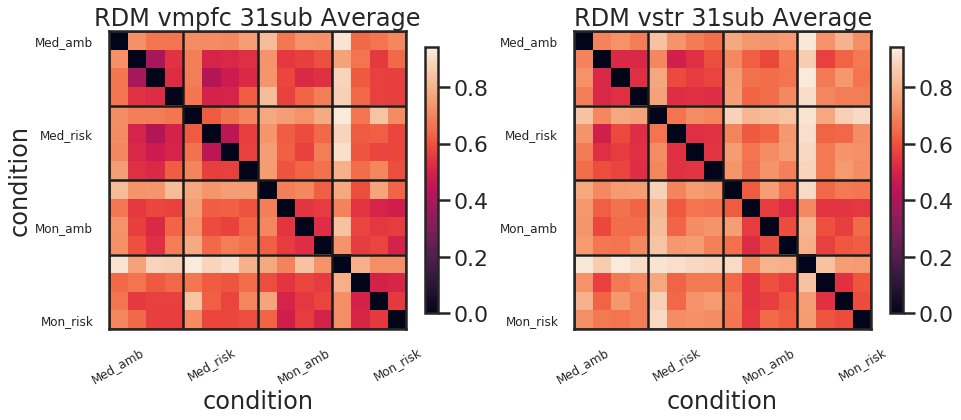

In [45]:
stim_cat = ['', 'Med_amb', 'Med_risk', 'Mon_amb', 'Mon_risk']
fontdict = {'fontsize': 12}
edges = np.array([0,4,8,12,16])-0.5
roi_names = list(roi_rdm.keys())

f, ax = plt.subplots(1,len(roi_names), figsize=(15, 7))

for roi_idx in range(len(roi_names)):
    im = ax[roi_idx].imshow(np.mean(roi_rdm[roi_names[roi_idx]], axis=0))
    ax[roi_idx].set_xticklabels(stim_cat, rotation = 30, fontdict = fontdict)
    ax[roi_idx].set_yticklabels(stim_cat, fontdict = fontdict)
    ax[roi_idx].set_title('RDM '+roi_names[roi_idx] + ' 31sub Average') 
    ax[roi_idx].set_xlabel('condition')
    if roi_idx == 0:
        ax[roi_idx].set_ylabel('condition')
    else:
        ax[roi_idx].set_ylabel('')
    ax[roi_idx].vlines(edges,min(edges),max(edges))
    ax[roi_idx].hlines(edges,min(edges),max(edges))
    f.colorbar(im, ax=ax[roi_idx], shrink = 0.7)


f.subplots_adjust(wspace = 0.25)

## Multidimentional scaling to visualize the distance between stimuli

In [ ]:
# from sklearn.manifold import MDS

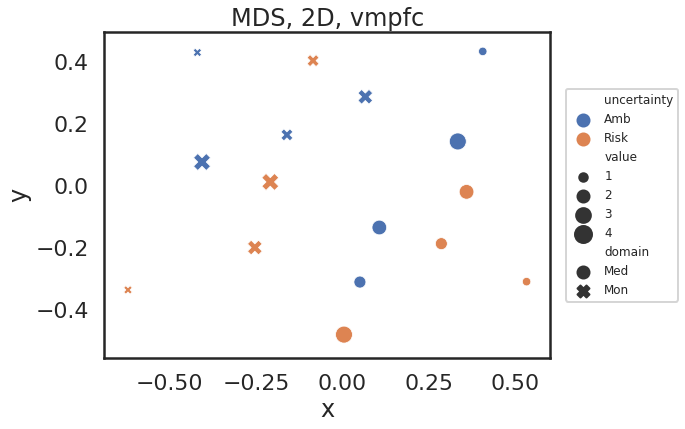

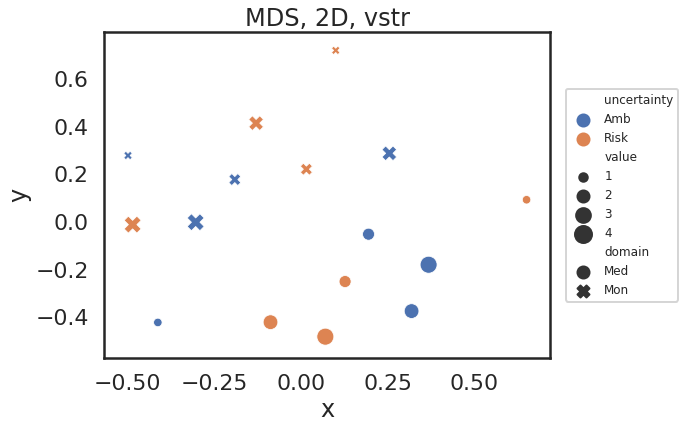

In [101]:
roi_rdm_mean = {}
for roi_name in roi_names:
    roi_rdm_mean[roi_name] = np.mean(roi_rdm[roi_name], axis=0)

for roi_name in roi_names:
    # Create the MDS object
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
    results = mds.fit(roi_rdm_mean[roi_name])
    
    coords = results.embedding_

    value = [1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4] 
    uncert = ['Amb','Amb','Amb','Amb','Risk','Risk','Risk','Risk',
              'Amb','Amb','Amb','Amb','Risk','Risk','Risk','Risk']
    domain = ['Med','Med','Med','Med','Med','Med','Med','Med',
              'Mon','Mon','Mon','Mon','Mon','Mon','Mon','Mon']

    mds_coord = pd.DataFrame({'x': coords[:,0], 'y': coords[:,1], 'value': value,
                'uncertainty': uncert, 'domain': domain})    

    f, ax = plt.subplots(1,1,figsize=(8, 6))
    ax = sns.scatterplot(x='x', y = 'y', 
                         size = 'value', hue = 'uncertainty', style = 'domain',
                         data=mds_coord, legend = 'full')
    plt.legend(fontsize = 12, markerscale = 1, loc = 'right', bbox_to_anchor=(1.3, .5))
    plt.title('MDS, 2D,' + ' ' + roi_name);

In [48]:
# stims = {'01': 'Med_amb_0', '02': 'Med_amb_1', '03': 'Med_amb_2', '04': 'Med_amb_3',
#          '05': 'Med_risk_0', '06': 'Med_risk_1', '07': 'Med_risk_2', '08': 'Med_risk_3', 
#          '09': 'Mon_amb_0', '10': 'Mon_amb_1', '11': 'Mon_amb_2', '12': 'Mon_amb_3',
#          '13': 'Mon_risk_0', '14': 'Mon_risk_1', '15': 'Mon_risk_2', '16': 'Mon_risk_3'}

# stim_num = len(stims)
# stim_names = list(stims.values())

## Model RDM

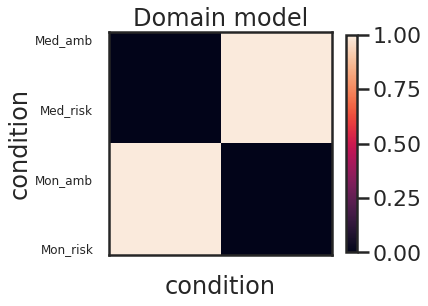

In [42]:
# Model RDM domain difference
mod_rdm_domain = np.ones([16,16])

med_id = list(range(8))
mon_id = list(range(8,16))

mon_mask = [(a,b) for a in mon_id for b in mon_id]
med_mask = [(a,b) for a in med_id for b in med_id]

for mon_mask_idx in mon_mask:  
    mod_rdm_domain[mon_mask_idx] = 0
for med_mask_idx in med_mask:  
    mod_rdm_domain[med_mask_idx] = 0

stim_cat = ['', 'Med_amb', 'Med_risk', 'Mon_amb', 'Mon_risk']
fontdict = {'fontsize': 12}
edges = np.array([0,4,8,12,16])-0.5

f, ax = plt.subplots(1,1, figsize=(5, 5))
im0 = ax.imshow(mod_rdm_domain)
ax.set_xticklabels([])
ax.set_yticklabels(stim_cat, fontdict = fontdict)
ax.set_title('Domain model') 
ax.set_ylabel('condition')
ax.set_xlabel('condition')
# ax.vlines(edges,min(edges),max(edges))
# ax.hlines(edges,min(edges),max(edges))
f.colorbar(im0, ax=ax, shrink = 0.8)

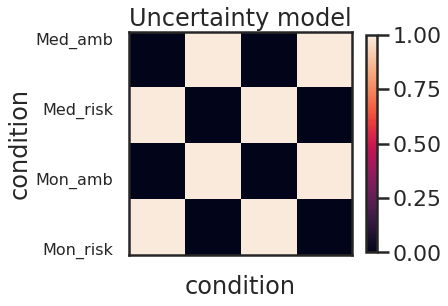

In [73]:
# Model RDM risk/ambig difference
mod_rdm_uncert = np.ones([16,16])

risk_id = [0,1,2,3,8,9,10,11]
amb_id = [4,5,6,7,12,13,14,15]

amb_mask = [(a,b) for a in risk_id for b in risk_id]
risk_mask = [(a,b) for a in amb_id for b in amb_id]

for risk_mask_idx in risk_mask:  
    mod_rdm_uncert[risk_mask_idx] = 0
for amb_mask_idx in amb_mask:  
    mod_rdm_uncert[amb_mask_idx] = 0

stim_cat = ['', 'Med_amb', 'Med_risk', 'Mon_amb', 'Mon_risk']
fontdict = {'fontsize': 16}
edges = np.array([0,4,8,12,16])-0.5

f, ax = plt.subplots(1,1, figsize=(5, 5))
im0 = ax.imshow(mod_rdm_uncert)
ax.set_xticklabels([])
ax.set_yticklabels(stim_cat, fontdict = fontdict)
ax.set_title('Uncertainty model') 
ax.set_xlabel('condition')
ax.set_ylabel('condition')
# ax.vlines(edges,min(edges),max(edges))
# ax.hlines(edges,min(edges),max(edges))
f.colorbar(im0, ax=ax, shrink = 0.8)

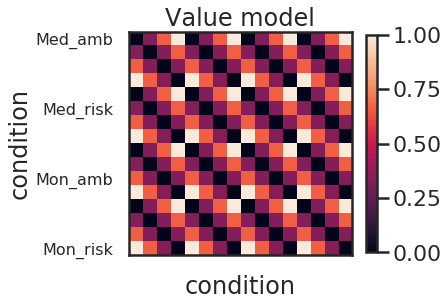

In [72]:
# Model RDM value (outcome magnitude) difference
mod_rdm_val = np.ones([16,16])

level = np.array([0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3])

for i in range(len(level)):
    for j in range(len(level)):
        mod_rdm_val[i, j] = abs(level[i] - level[j])/3
        
stim_cat = ['', 'Med_amb', 'Med_risk', 'Mon_amb', 'Mon_risk']
fontdict = {'fontsize': 16}
edges = np.array([0,4,8,12,16])-0.5

f, ax = plt.subplots(1,1, figsize=(5, 5))
im0 = ax.imshow(mod_rdm_val)
ax.set_xticklabels([])
ax.set_yticklabels(stim_cat, fontdict = fontdict)
ax.set_title('Value model') 
ax.set_xlabel('condition')
ax.set_ylabel('condition')
# ax.vlines(edges,min(edges),max(edges))
# ax.hlines(edges,min(edges),max(edges))
f.colorbar(im0, ax=ax, shrink = 0.8)        

## Model comparison

In [75]:
# single subject
subjects = [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 
            2593, 2594, 2596, 2597, 2598, 2600, 2624, 2650, 
            2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 
            2659, 2660, 2662, 2663, 2664, 2665, 2666]

# subjects = [2073]

# all models to compare
mod_rdm = {'domain': mod_rdm_domain, 'uncertainty': mod_rdm_uncert, 
          'value': mod_rdm_val}
# vectorize
mod_rdm_vector = {mod_name: 
                  mod_rdm[mod_name].reshape(mod_rdm[mod_name].shape[0]*mod_rdm[mod_name].shape[1],)
                  for mod_name in list(mod_rdm.keys())} 
 

In [82]:
# calculate spearman correlation between rdm and model rdm
# for each model, each roi, each subject

spearman_r = {'domain': {}, 'uncertainty': {}, 'value': {}}
spearman_p = {'domain': {}, 'uncertainty': {}, 'value': {}}

for (mod_idx, mod_name) in enumerate(list(mod_rdm_vector.keys())):
    
    spearman_r_mod = {'vmpfc': [], 'vstr': []}
    spearman_p_mod = {'vmpfc': [], 'vstr': []}

    for sub in subjects:
        roi_rdm_obj = np.load('/home/rj299/project/mdm_analysis/output/imaging/Sink_rsa/rdm/_subject_id_%s/roi_rdm.npy' %sub,
               allow_pickle = True)
        
        # get dictionary type
        roi_rdm = roi_rdm_obj.item()

        roi_names = list(roi_rdm.keys())

        for (roi_idx, roi_name) in enumerate(roi_names):
            # spearman bween model rdm and individual rdm
            rdm_vector = roi_rdm[roi_name].reshape(roi_rdm[roi_name].shape[0]*roi_rdm[roi_name].shape[1], )

            rho, pvalue = stats.spearmanr(rdm_vector, mod_rdm_vector[mod_name])
            spearman_r_mod[roi_name].append(rho)
            spearman_p_mod[roi_name].append(pvalue)
            
    spearman_r[mod_name] = spearman_r_mod
    spearman_p[mod_name] = spearman_p_mod

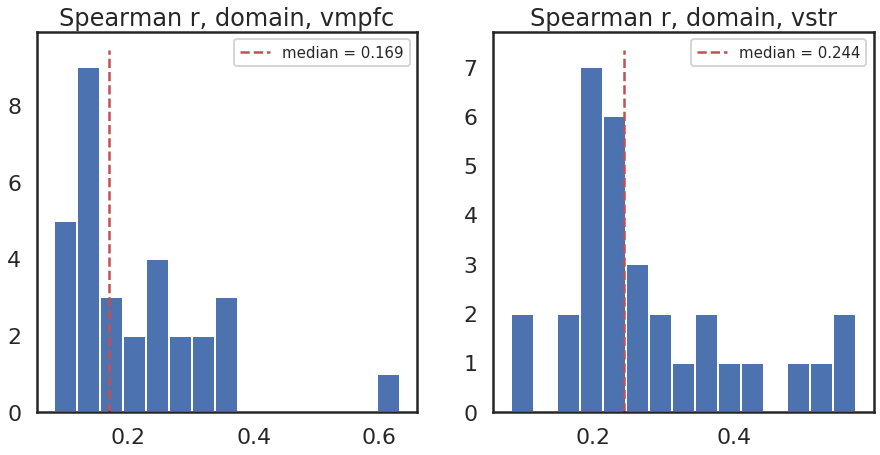

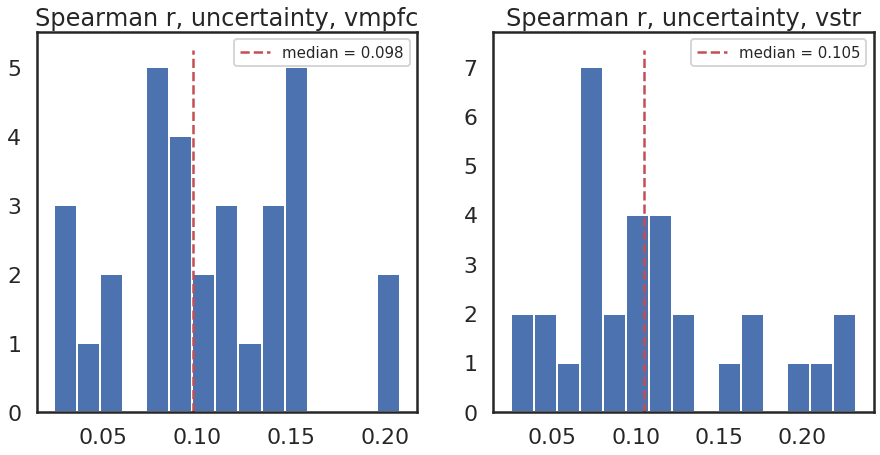

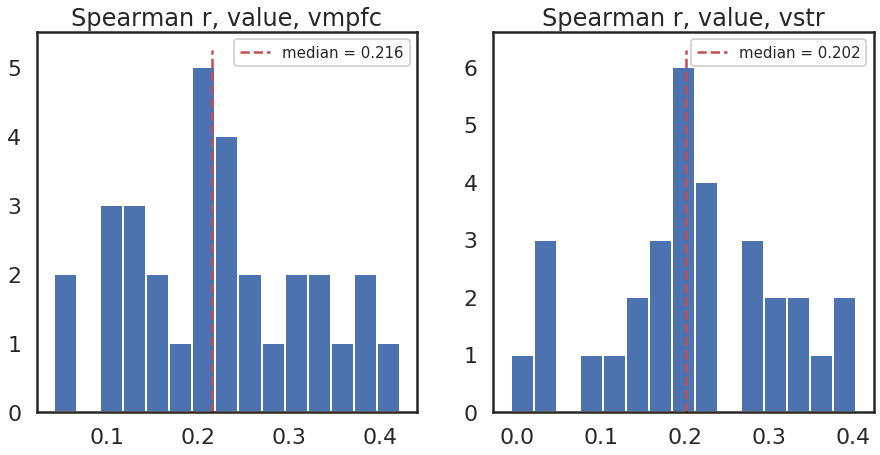

In [104]:
# plot spearman r distribution
for (mod_idx, mod_name) in enumerate(list(mod_rdm_vector.keys())):
    
    f, ax = plt.subplots(1, len(roi_names), figsize = (15,7))
    for (roi_idx, roi_name) in enumerate(roi_names):
        # plot distribution
        ax[roi_idx].hist(spearman_r[mod_name][roi_name], bins = 15)
        # plot median
        median = np.median(spearman_r[mod_name][roi_name])
        ax[roi_idx].vlines(median, ymin=0, ymax=ax[roi_idx].get_ylim()[1], 
                           colors = 'r', linestyles = 'dashed')
        ax[roi_idx].legend(['median = %s' %round(median,3)], fontsize = 15)
        ax[roi_idx].set_title('Spearman r, '+mod_name+', '+roi_name)
        

In [142]:
# permutation test
# for each subject, permutate 100 times
# each permutation: calculate spearman correlation between rdm and model rdm
# for each model, each roi, calculate the mean for a single subject

perm_num = 1000 # number of iteration
spearman_r_perm = {'domain': {}, 'uncertainty': {}, 'value': {}}
roi_names = ['vmpfc', 'vstr']

# each model
for (mod_idx, mod_name) in enumerate(list(mod_rdm_vector.keys())):
    
    spearman_r_perm_mod = {'vmpfc': [], 'vstr': []}
    
    # each ROI
    for (roi_idx, roi_name) in enumerate(roi_names):
    
        for perm_idx in range(perm_num):
            # randomly select a subject
            sub = np.random.choice(subjects)
            roi_rdm_obj = np.load('/home/rj299/project/mdm_analysis/output/imaging/Sink_rsa/rdm/_subject_id_%s/roi_rdm.npy' %sub,
                                  allow_pickle = True)
        
            # get dictionary type
            roi_rdm = roi_rdm_obj.item()
        
            # spearman bween model rdm and individual rdm
            rdm_vector = roi_rdm[roi_name].reshape(roi_rdm[roi_name].shape[0]*roi_rdm[roi_name].shape[1], )
            
            rdm_vector_perm = np.random.permutation(rdm_vector)
            rho_i, pvalue_i = stats.spearmanr(rdm_vector_perm, mod_rdm_vector[mod_name])
                
            spearman_r_perm_mod[roi_name].append(rho_i)
        
    spearman_r_perm[mod_name] = spearman_r_perm_mod


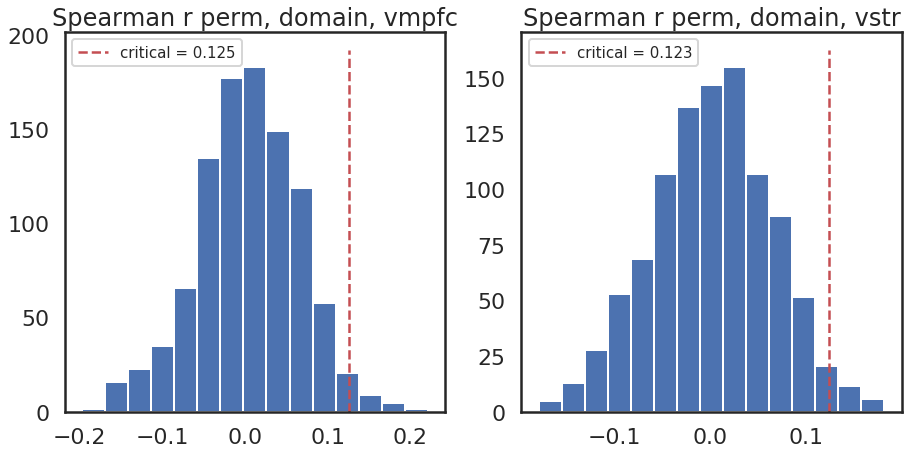

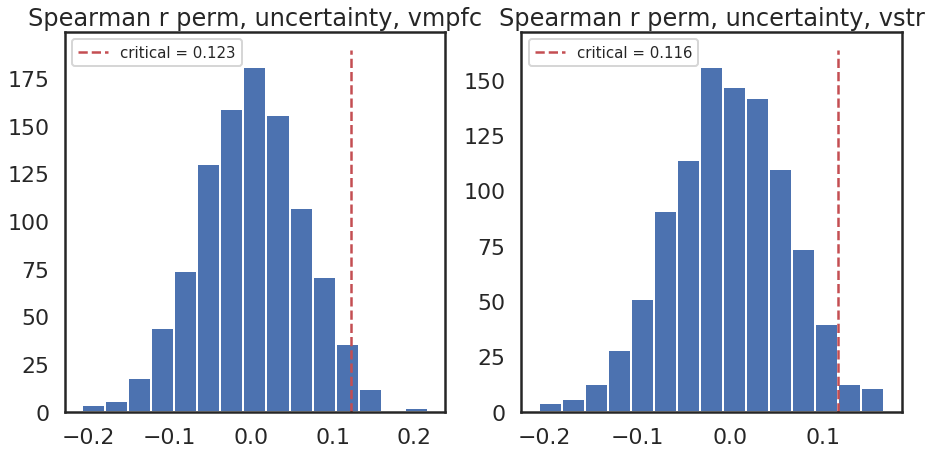

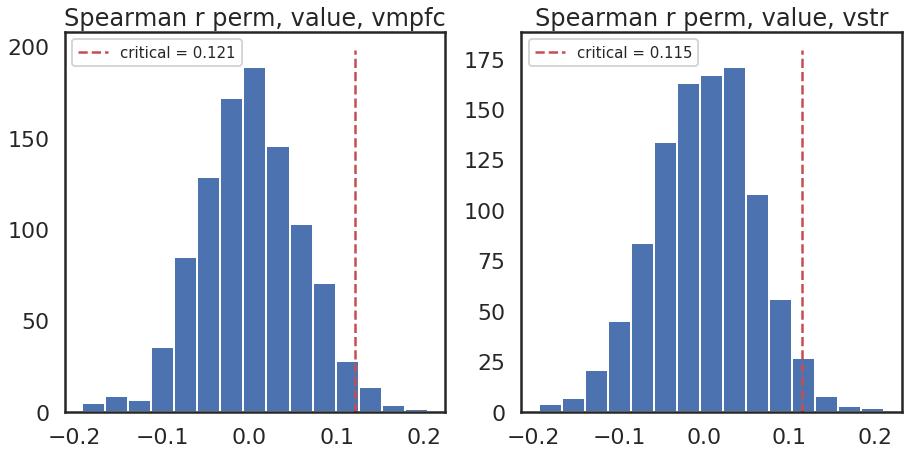

In [143]:
# plot spearman r distribution
sig_level = 0.05

for (mod_idx, mod_name) in enumerate(list(mod_rdm_vector.keys())):
    
    f, ax = plt.subplots(1, len(roi_names), figsize = (15,7))
    for (roi_idx, roi_name) in enumerate(roi_names):
        # plot distribution
        ax[roi_idx].hist(spearman_r_perm[mod_name][roi_name], bins = 15)
        
        # plot critical value
        n_iter = len(spearman_r_perm[mod_name][roi_name])
        # two-tailed
        critical_idx = int(n_iter * (1-sig_level/2))
        r_sorted = np.sort(spearman_r_perm[mod_name][roi_name])
        critical = r_sorted[critical_idx]
        ax[roi_idx].vlines(critical, ymin=0, ymax=ax[roi_idx].get_ylim()[1], 
                           colors = 'r', linestyles = 'dashed')
        ax[roi_idx].legend(['critical = %s' %round(critical,3)], 
                           fontsize = 15,
                          loc = 'upper left')
        
        ax[roi_idx].set_title('Spearman r perm, '+mod_name+', '+roi_name)
        
        